#### Bike Sharing Dataset | Linear Regression Model


#### License

Use of this dataset in publications must be cited to the following publication:

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

@article{
  year={2013},
  issn={2192-6352},
  journal={Progress in Artificial Intelligence},
  doi={10.1007/s13748-013-0040-3},
  title={Event labeling combining ensemble detectors and background knowledge},
  url={http://dx.doi.org/10.1007/s13748-013-0040-3},
  publisher={Springer Berlin Heidelberg},
  keywords={Event labeling; Event detection; Ensemble learning; Background knowledge},
  author={Fanaee-T, Hadi and Gama, Joao},
  pages={1-15}
}

Contact

For further information about this dataset please contact Hadi Fanaee-T (hadi.fanaee@fe.up.pt)


#### 1. **Introduction**
   - **Objective:** 
   The goal of this analysis is to build a multiple linear regression model to predict bike demand and understand the significant factors influencing it. By analyzing the dataset, we aim to derive insights that can help BoomBikes optimize their operations and meet customer demand efficiently.


   - **Business Understanding:** BoomBikes is a bike-sharing company that seeks to understand the patterns in bike usage to optimize their fleet management. Predicting bike demand accurately is crucial for ensuring that bikes are available when and where customers need them. This analysis will help identify the key factors affecting bike demand and enable data-driven decision-making for inventory management, marketing strategies, and operational improvements.



#### 2. **Data Understanding**
   - **Load the Data:** Load the dataset (`day.csv`) and display the first few rows to understand its structure.
   - **Data Dictionary:** Below is a brief overview of the columns present in the dataset:

         | Column Name   | Description                                                                     |
         |---------------|---------------------------------------------------------------------------------|
         | instant       | Record index                                                                    |
         | dteday        | Date                                                                            |
         | season        | Season (1: winter, 2: spring, 3: summer, 4: fall)                               |
         | yr            | Year (0: 2018, 1: 2019)                                                         |
         | mnth          | Month (1 to 12)                                                                 |
         | holiday       | Whether the day is a holiday (0: No, 1: Yes)                                    |
         | weekday       | Day of the week (0 to 6)                                                        |
         | workingday    | If the day is neither a weekend nor a holiday (1/0)                             |
         | weathersit    | Weather situation (1: clear, 2: cloudy, 3: light rain/snow), 4: Heavy rain/snow |
         | temp          | temperature in Celsius                                                          |
         | atemp         | feeling temperature in Celsius                                                  |
         | hum           | humidity                                                                        |
         | windspeed     | wind speed                                                                      |
         | casual        | Count of casual users                                                           |
         | registered    | Count of registered users                                                       |
         | cnt           | Count of total rental bikes                                                     |

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", palette='pastel')

In [2]:
def ct_x_by_vol(data: pd.DataFrame, row, volume):
    """
    Creates cross tab
    """

    # print (f'--------{row} x {volume}----------')
    grouped_data = data.groupby(row, observed=False)[volume].sum().reset_index()
    total_cnt = grouped_data[volume].sum()
    grouped_data['percentage'] = (grouped_data[volume] / total_cnt) * 100
    pivot_table = pd.pivot_table(data, values=volume, index=row, aggfunc='sum', observed=False)
    pivot_table['percentage'] = ((pivot_table[volume] / pivot_table[volume].sum()) * 100).round(2)
    
    # print(pivot_table)
    # return grouped_data, pivot_table
    return pivot_table


def ct_x_by_y_by_vol(data: pd.DataFrame, row: str, col: str, volume: str):
    """
    Creates a cross tabulation of the volume
    """

    # print(f'-------- {row} x {col} x {volume} --------')
    pivot_table = pd.pivot_table(data, values=volume, index=row, columns=col, aggfunc='sum', observed=False)
    total_volume = pivot_table.values.sum()
    pivot_table_percentage = (pivot_table / total_volume) * 100
    combined_table = pivot_table.copy()
    for col in pivot_table.columns:
        combined_table[f'{col}_percentage'] = pivot_table_percentage[col]
    
    combined_table = combined_table.round(2)
    
    # print(combined_table)
    return combined_table

In [3]:
# Load the dataset
data = pd.read_csv('day.csv')

# Display the first few rows of the dataset
data.head(n=10)

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   
5        6  06-01-2018       1   0     1        0        4           1   
6        7  07-01-2018       1   0     1        0        5           1   
7        8  08-01-2018       1   0     1        0        6           0   
8        9  09-01-2018       1   0     1        0        0           0   
9       10  10-01-2018       1   0     1        0        1           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   
5           1   8.378268  11.66045  51.8261   6.000868      88        1518   
6           2   8.057402  10.44195  49.8696  11.304642     148        1362   
7           2   6.765000   8.11270  53.5833  17.875868      68         891   
8           1   5.671653   5.80875  43.4167  24.250650      54         768   
9           1   6.184153   7.54440  48.2917  14.958889      41        1280   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
5  1606  
6  1510  
7   959  
8   822  
9  1321


#### 3. **Data Cleaning**
   - **Missing Values:** Identify and handle any missing values appropriately.
   - **Invalid Values:** Check for and correct any invalid data entries.
   - **Formatting Issues:** Ensure consistent formatting for all columns.


    -----

    # We are dropping `dteday` column as it is incorrect and does not align with `holiday`, `weekday` and `workingday`.
    # We cannot correct this data based on dteday as volume `cnt` stops making sense in that case

    -----

In [4]:
# dropping dteday
data = data.drop(columns=['dteday'])

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values


instant       0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# Checking for invalid data entries in categorical variables
unique_vals = {
    'season': data['season'].unique(),
    'yr': data['yr'].unique(),
    'mnth': data['mnth'].unique(),
    'holiday': data['holiday'].unique(),
    'weekday': data['weekday'].unique(),
    'workingday': data['workingday'].unique(),
    'weathersit': data['weathersit'].unique()
}
unique_vals


{'season': array([1, 2, 3, 4]),
 'yr': array([0, 1]),
 'mnth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'holiday': array([0, 1]),
 'weekday': array([6, 0, 1, 2, 3, 4, 5]),
 'workingday': array([0, 1]),
 'weathersit': array([2, 1, 3])}

In [7]:
# Checking range for numerical variables
numerical_summary = data.describe()
numerical_summary

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

In [8]:
# Checking data types
data_types = data.dtypes
data_types

instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [9]:
# Converting necessary columns to categorical
categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
data[categorical_columns] = data[categorical_columns].astype('category')

# Verifying the changes
data.dtypes

instant          int64
season        category
yr            category
mnth          category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object

In [10]:
# Mapping categorical variables to their correct labels
data['season'] = data['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
data['weathersit'] = data['weathersit'].map({1: 'clear', 2: 'mist/cloud', 3: 'light rain/snow', 4: 'heavy rain/snow'})
data['weekday'] = data['weekday'].map({0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'})
data['mnth'] = data['mnth'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

# Display the first few rows to verify the changes
data.head()

instant  season yr     mnth holiday    weekday workingday  weathersit  \
0        1  spring  0  January       0   Saturday          0  mist/cloud   
1        2  spring  0  January       0     Sunday          0  mist/cloud   
2        3  spring  0  January       0     Monday          1       clear   
3        4  spring  0  January       0    Tuesday          1       clear   
4        5  spring  0  January       0  Wednesday          1       clear   

        temp     atemp      hum  windspeed  casual  registered   cnt  
0  14.110847  18.18125  80.5833  10.749882     331         654   985  
1  14.902598  17.68695  69.6087  16.652113     131         670   801  
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349  
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562  
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600


#### 4. **Exploratory Data Analysis (EDA)** 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

For our bike ride-sharing dataset covering the years 2018 and 2019, we aim to understand the factors that `drive volume (cnt)`. Our EDA will focus on examining the `impact of each variable on volume` and exploring `how the two years differ from each other`. This analysis will provide valuable insights and guide the subsequent `steps in building an effective linear regression model`.

<Figure size 1500x1000 with 0 Axes>

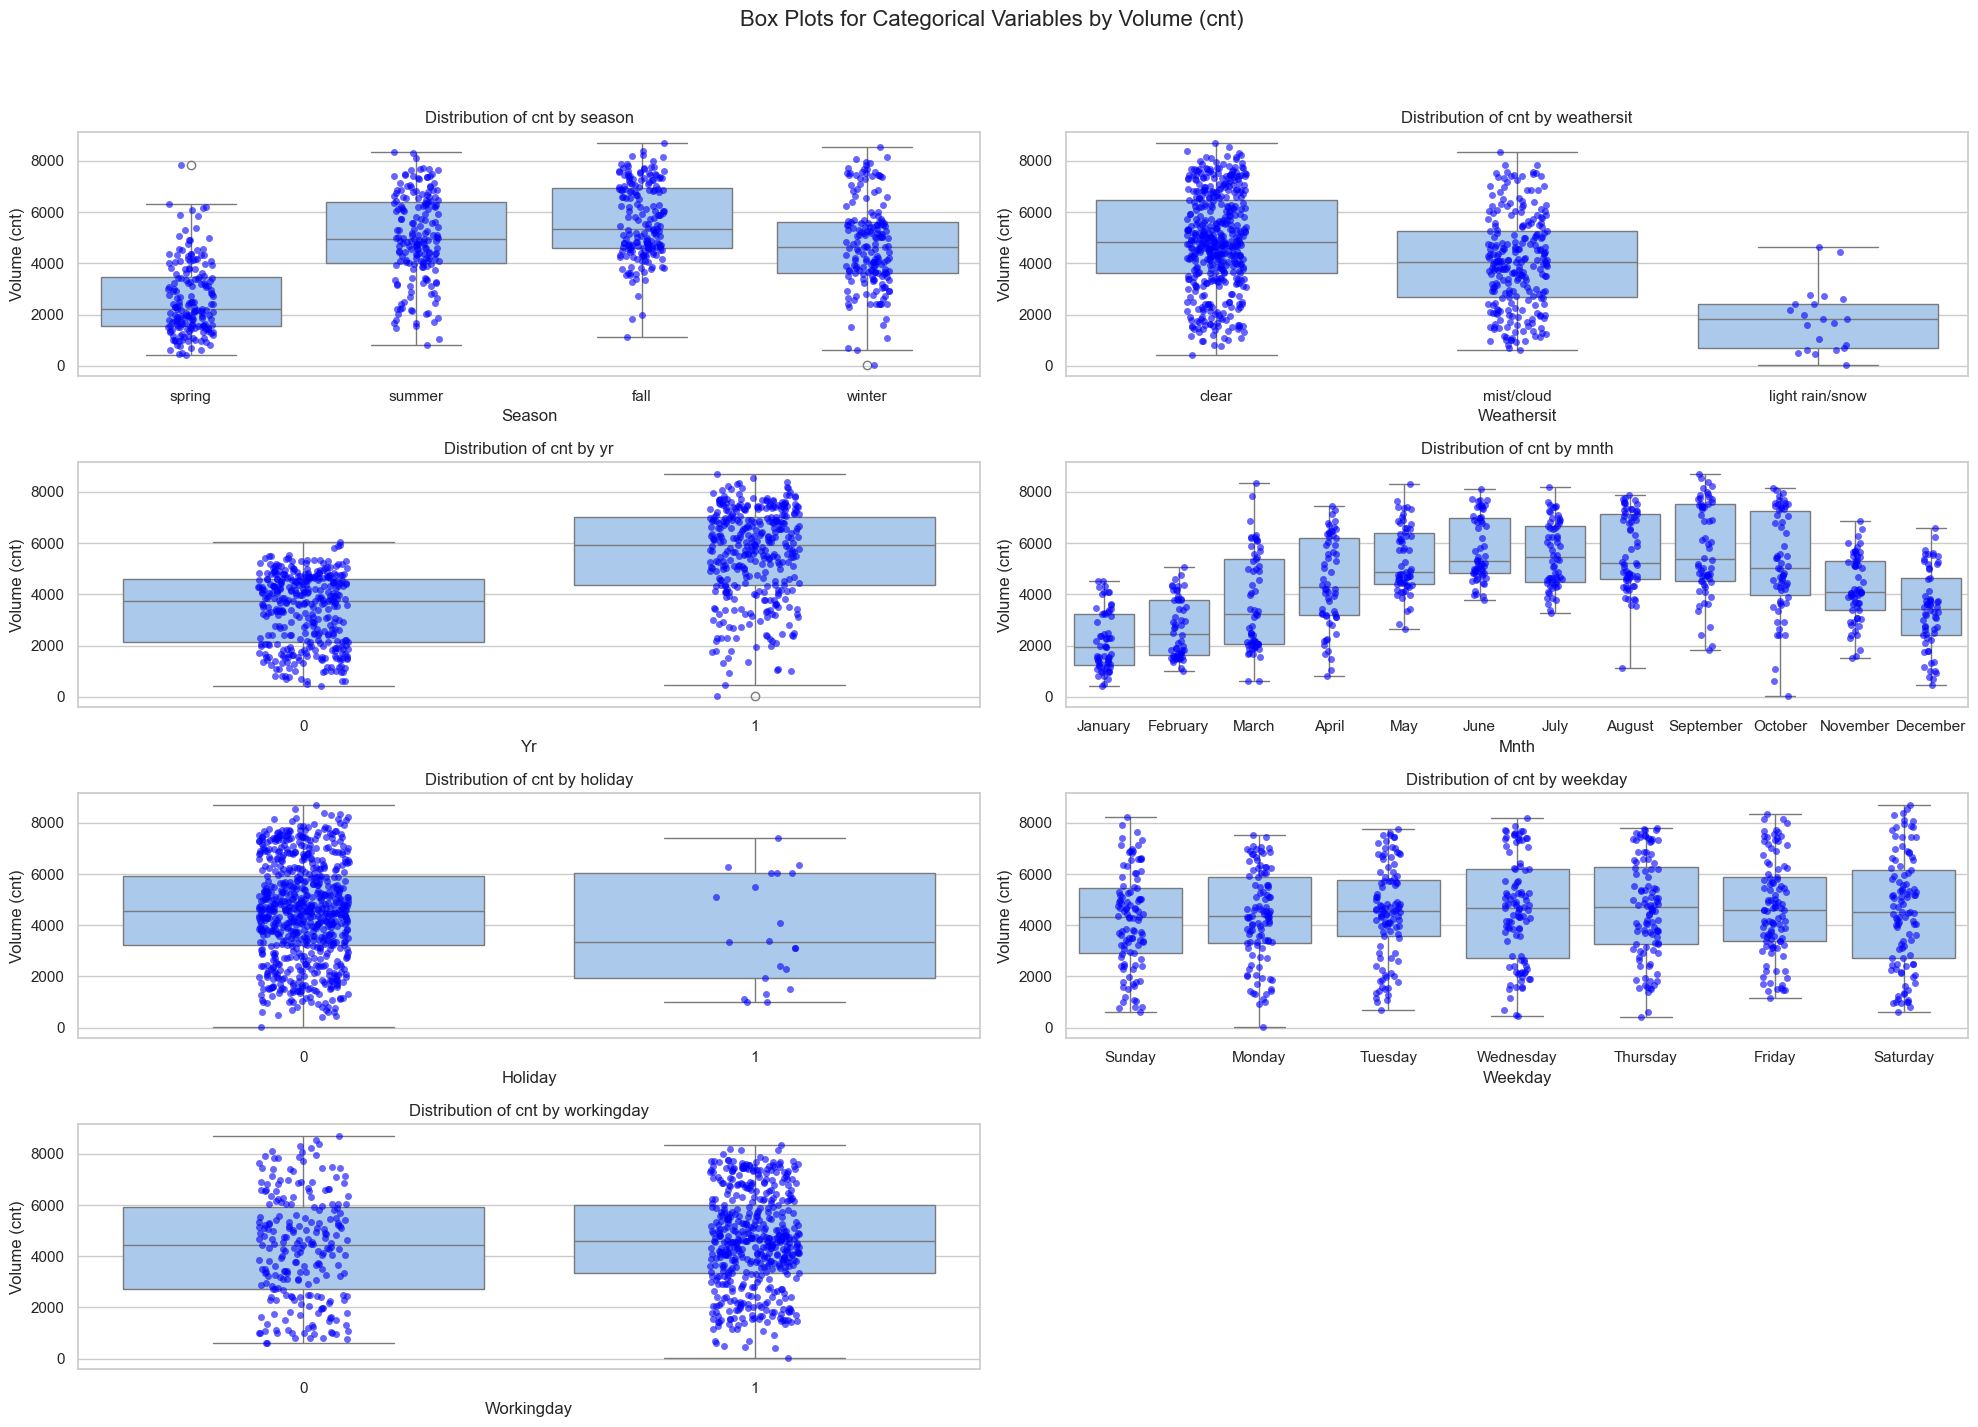

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the plot size and style
plt.figure(figsize=(15, 10))

# Plotting box plots for categorical variables against 'cnt'
categorical_vars = ['season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
fig.suptitle('Box Plots for Categorical Variables by Volume (cnt)', fontsize=16)

for i, var in enumerate(categorical_vars):
    row, col = divmod(i, 2)
    sns.boxplot(x=var, y='cnt', data=data, ax=axes[row, col])
    sns.stripplot(x=var, y='cnt', data=data, ax=axes[row, col], color='blue', alpha=0.6, jitter=True)
    axes[row, col].set_title(f'Distribution of cnt by {var}')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_ylabel('Volume (cnt)')

# Remove the extra subplot (axes[3, 1]) if the number of categorical variables is odd
fig.delaxes(axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


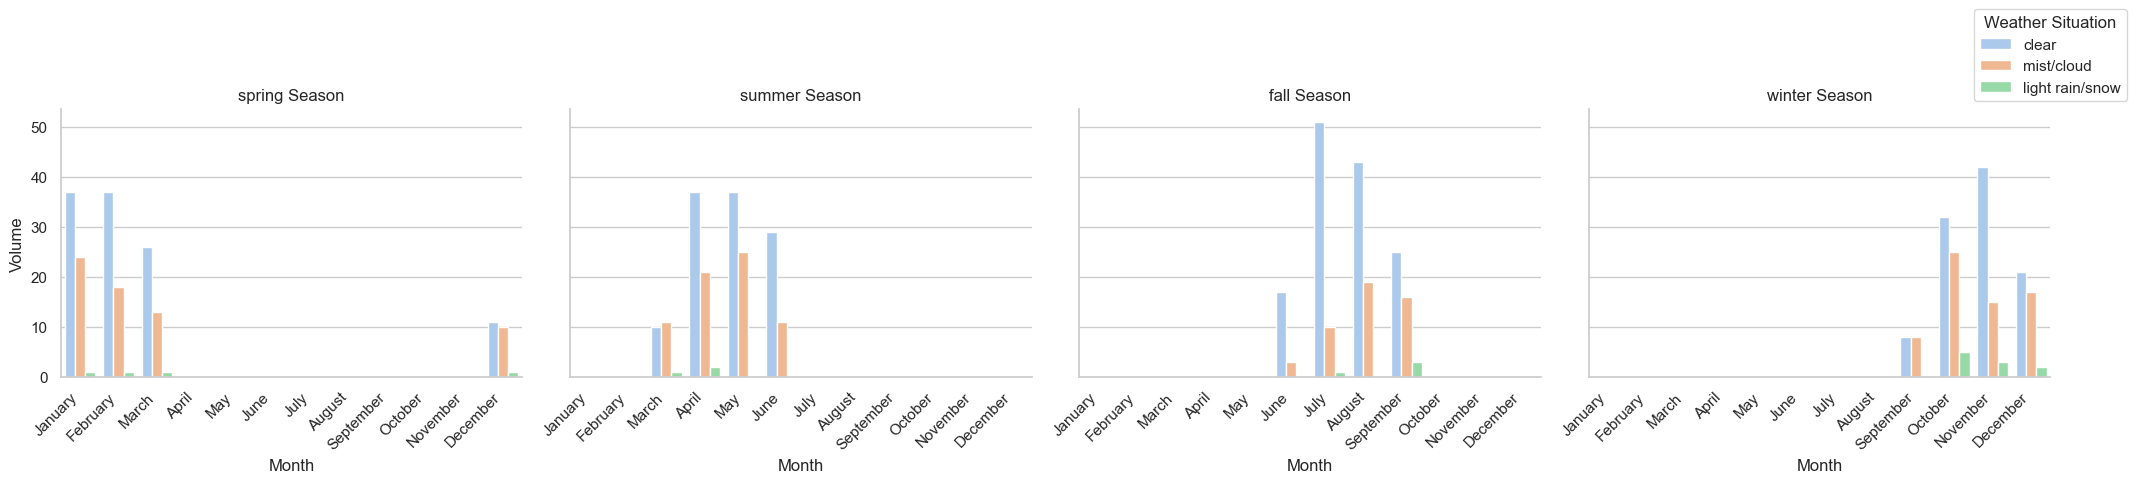

In [13]:
# Creating the count plot with Facet Grid
g = sns.catplot(
    data=data, 
    x='mnth', 
    hue='weathersit', 
    col='season', 
    kind='count', 
    height=5, 
    aspect=1,
    palette='pastel',
)

for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(title='Weather Situation', bbox_to_anchor=(1, 1), loc='lower center', ncol=1)
g.set_axis_labels("Month", "Volume")
g.set_titles("{col_name} Season")
g._legend.remove()
plt.tight_layout()
plt.show()

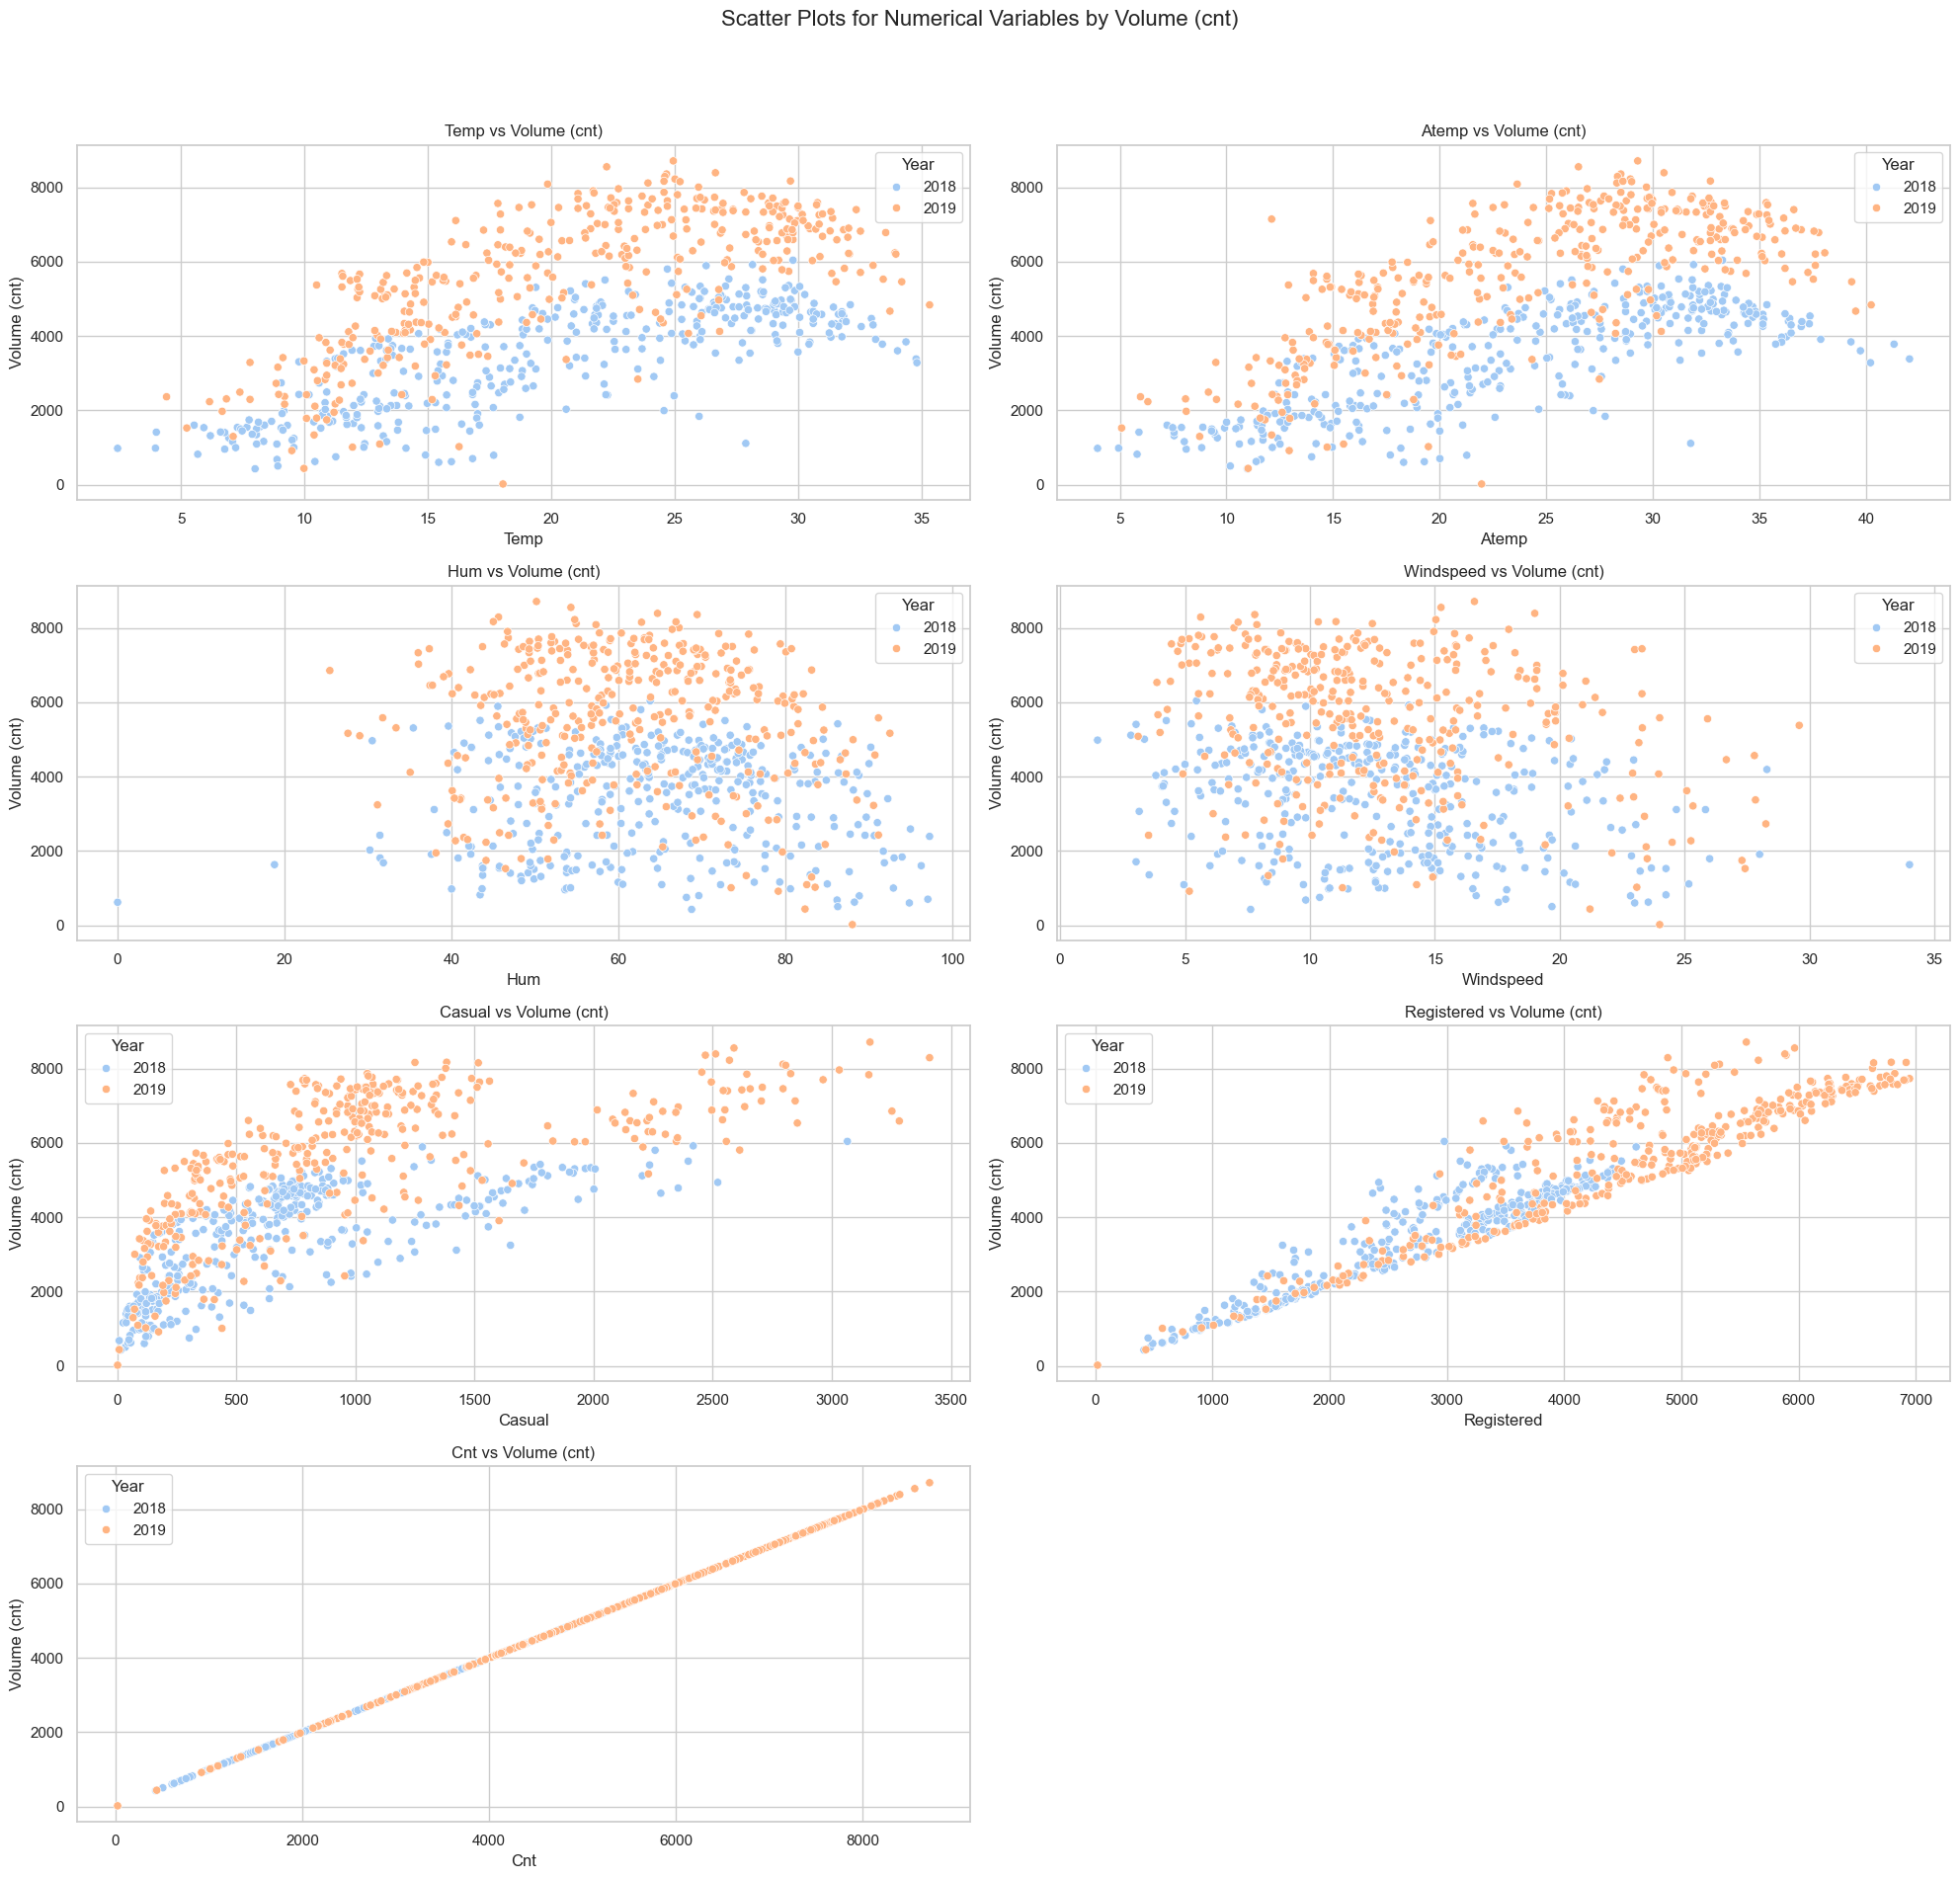

In [14]:
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Scatter Plots for Numerical Variables by Volume (cnt)', fontsize=16)

for i, var in enumerate(numerical_vars):
    row, col = divmod(i, 2)
    sns.scatterplot(x=var, y='cnt', data=data, ax=axes[row, col], hue='yr', palette="pastel")
    axes[row, col].set_title(f'{var.capitalize()} vs Volume (cnt)')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_ylabel('Volume (cnt)')
    handles, labels = axes[row, col].get_legend_handles_labels()
    labels = ['2018' if label == '0' else '2019' for label in labels]
    axes[row, col].legend(handles=handles, labels=labels, title='Year')

fig.delaxes(axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Figure size 1500x1000 with 0 Axes>

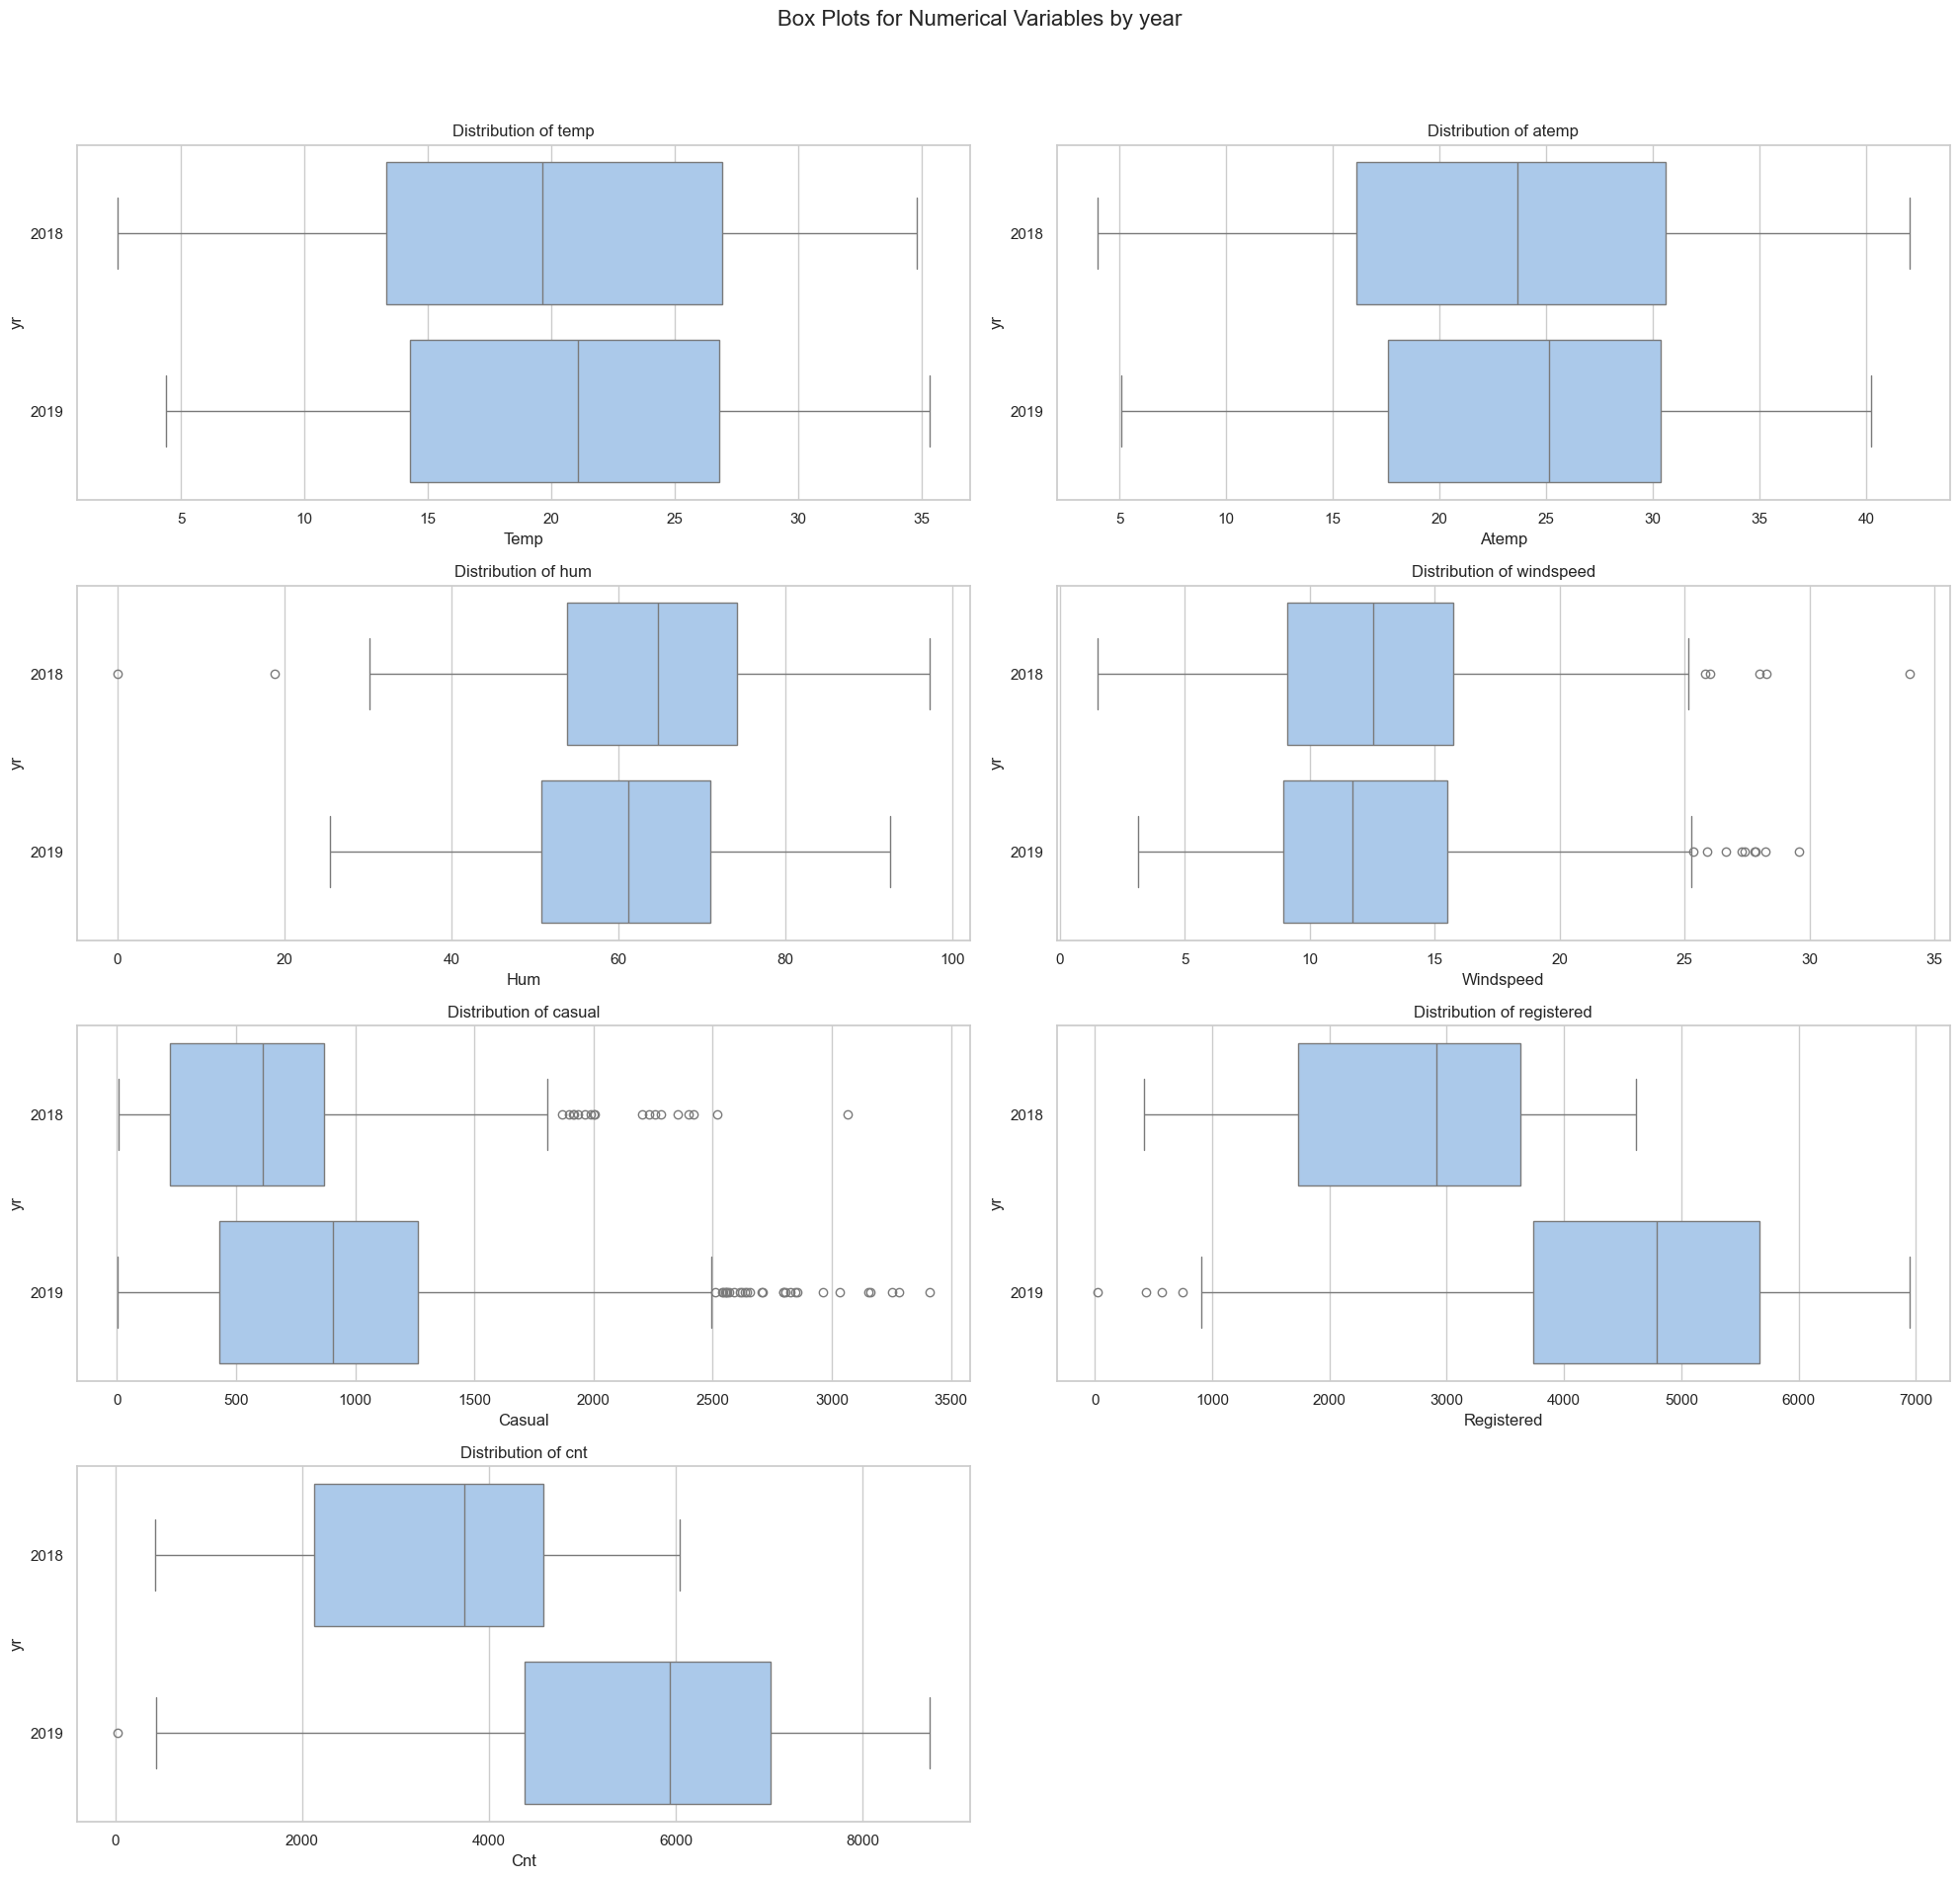

In [15]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid", palette="pastel")

numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Box Plots for Numerical Variables by year', fontsize=16)

for i, var in enumerate(numerical_vars):
    row, col = divmod(i, 2)
    # sns.boxplot(y=var, data=data, ax=axes[row, col], palette="pastel")
    sns.boxplot(x=var, y='yr', data=data, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var.capitalize())
    axes[row, col].set_yticks([0, 1])
    axes[row, col].set_yticklabels(['2018', '2019'])   

fig.delaxes(axes[3, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

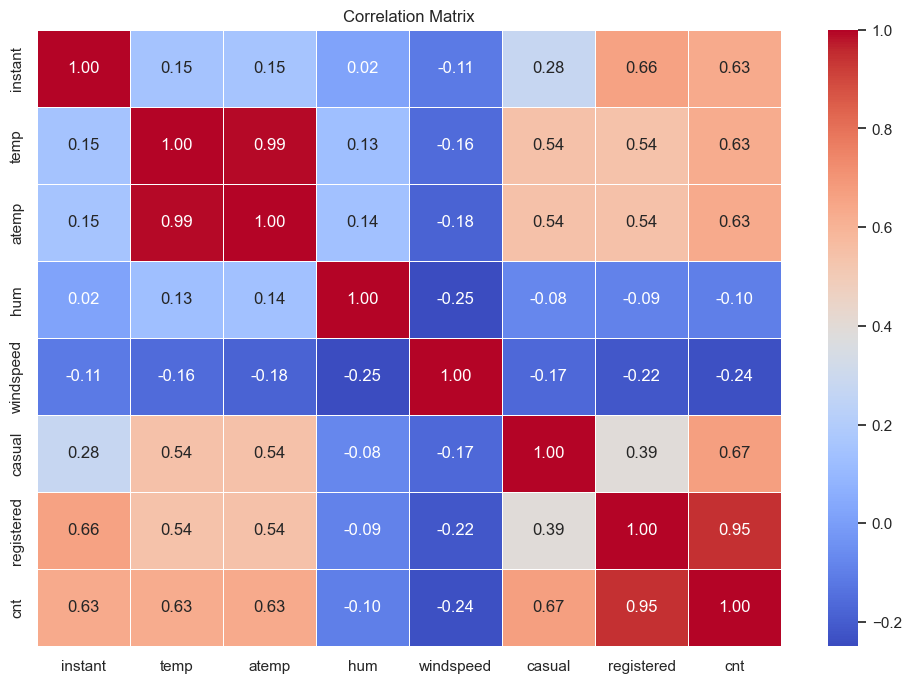

In [16]:
# Computing the correlation matrix
corr_matrix = data.corr(numeric_only=True)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

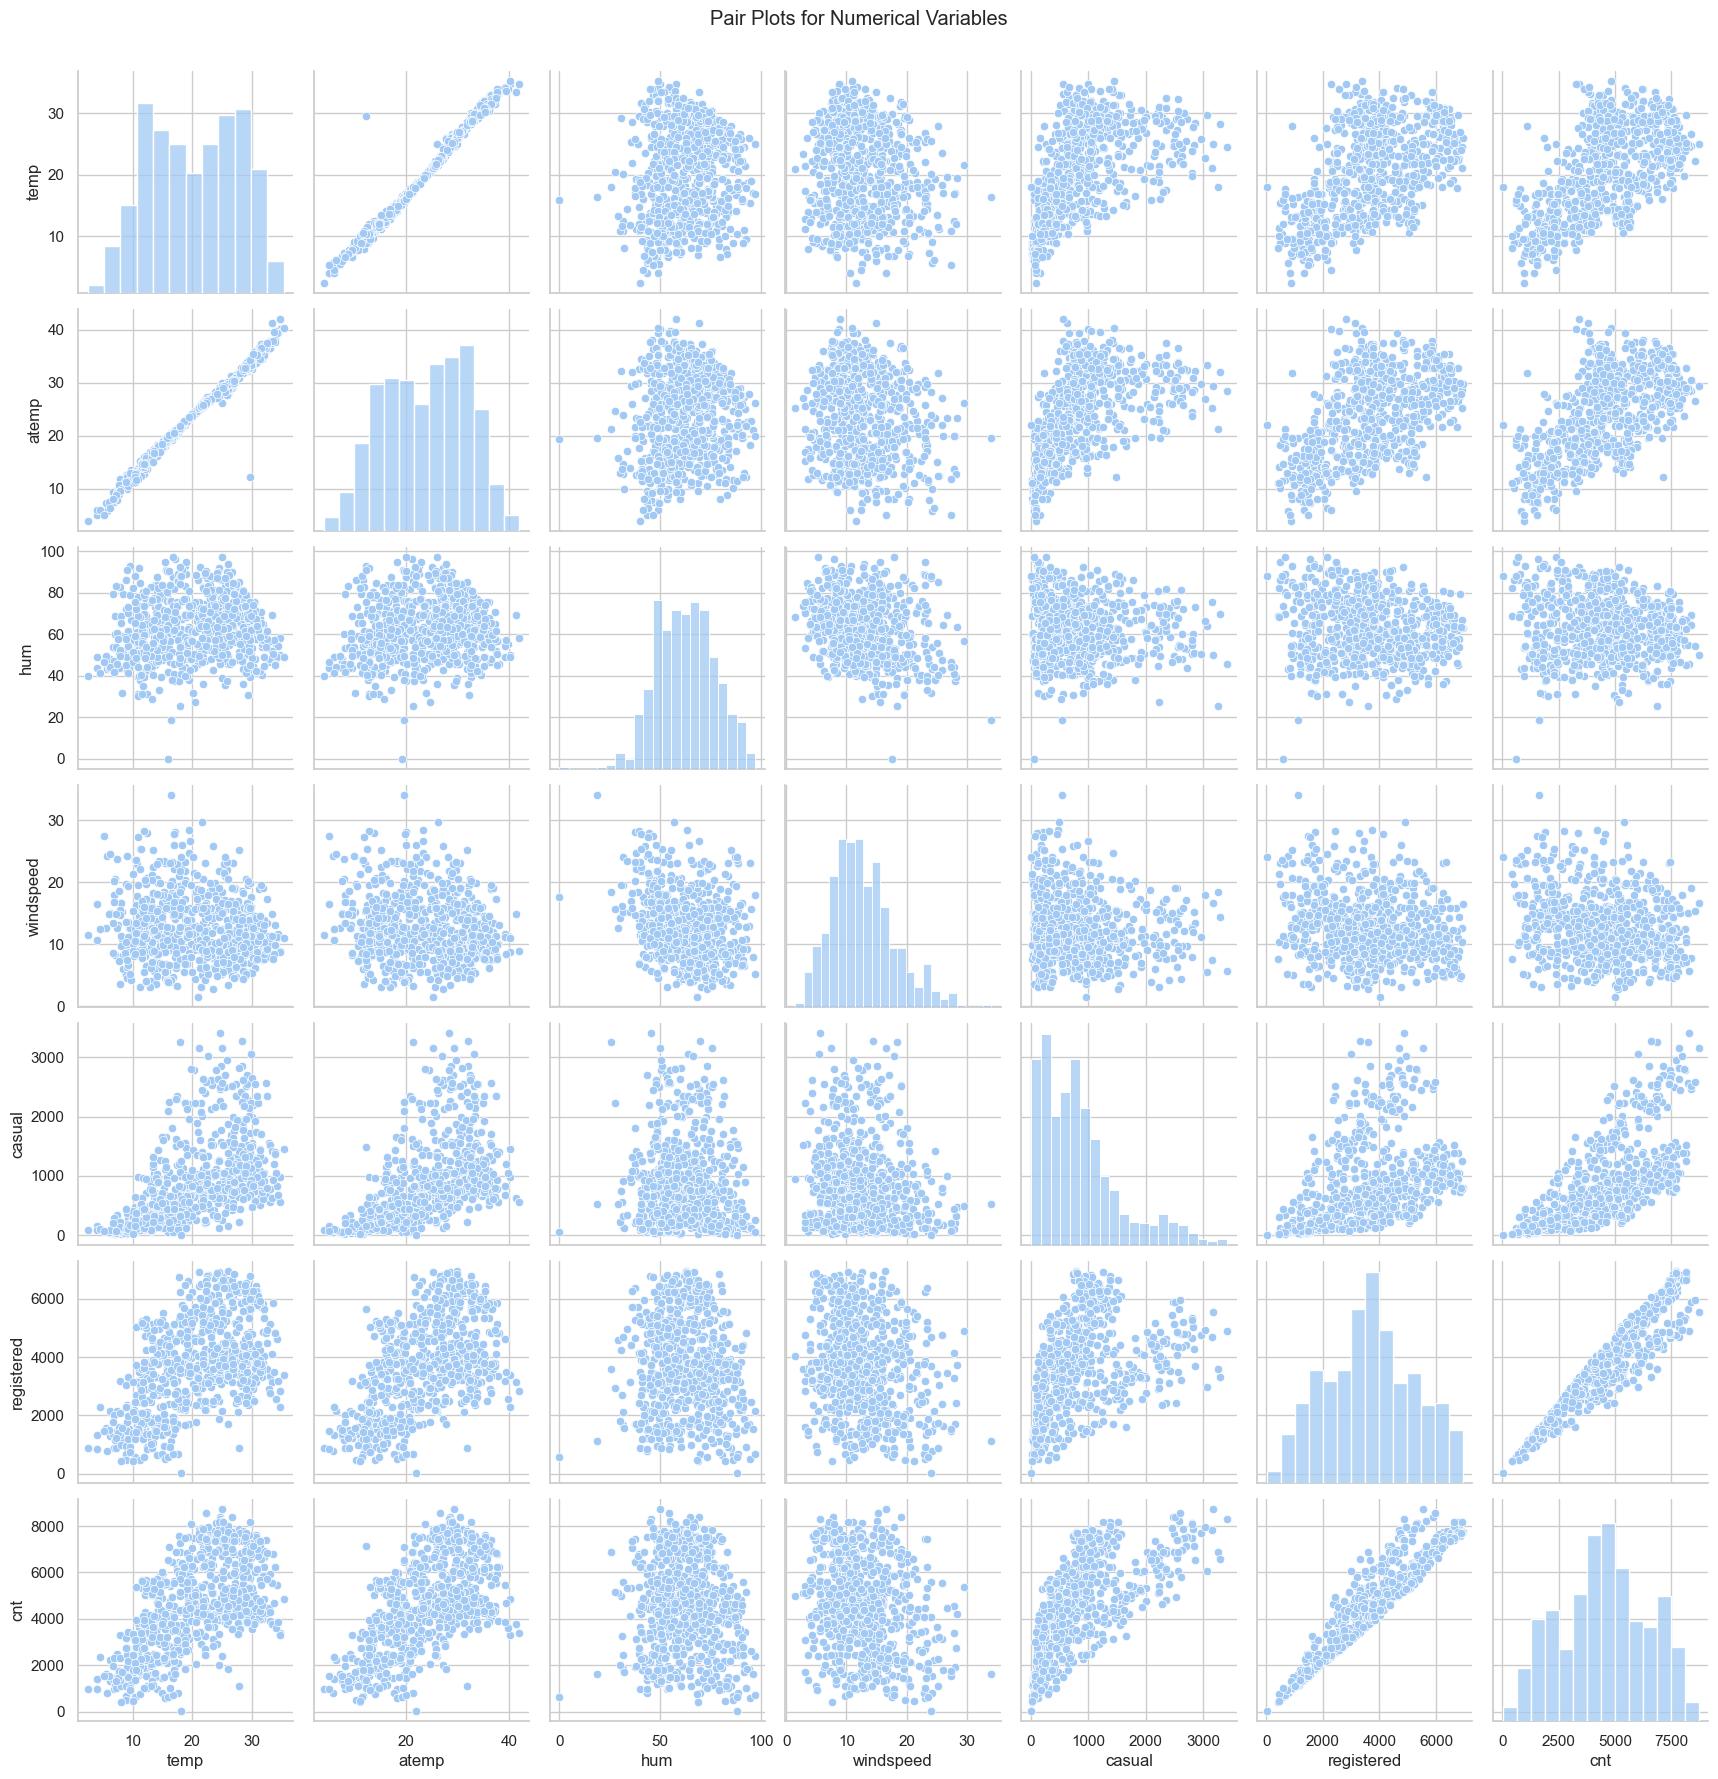

In [17]:
# Creating pair plots for numerical variables
sns.pairplot(data[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']], kind='scatter')
plt.suptitle('Pair Plots for Numerical Variables', y=1.02)
plt.show()

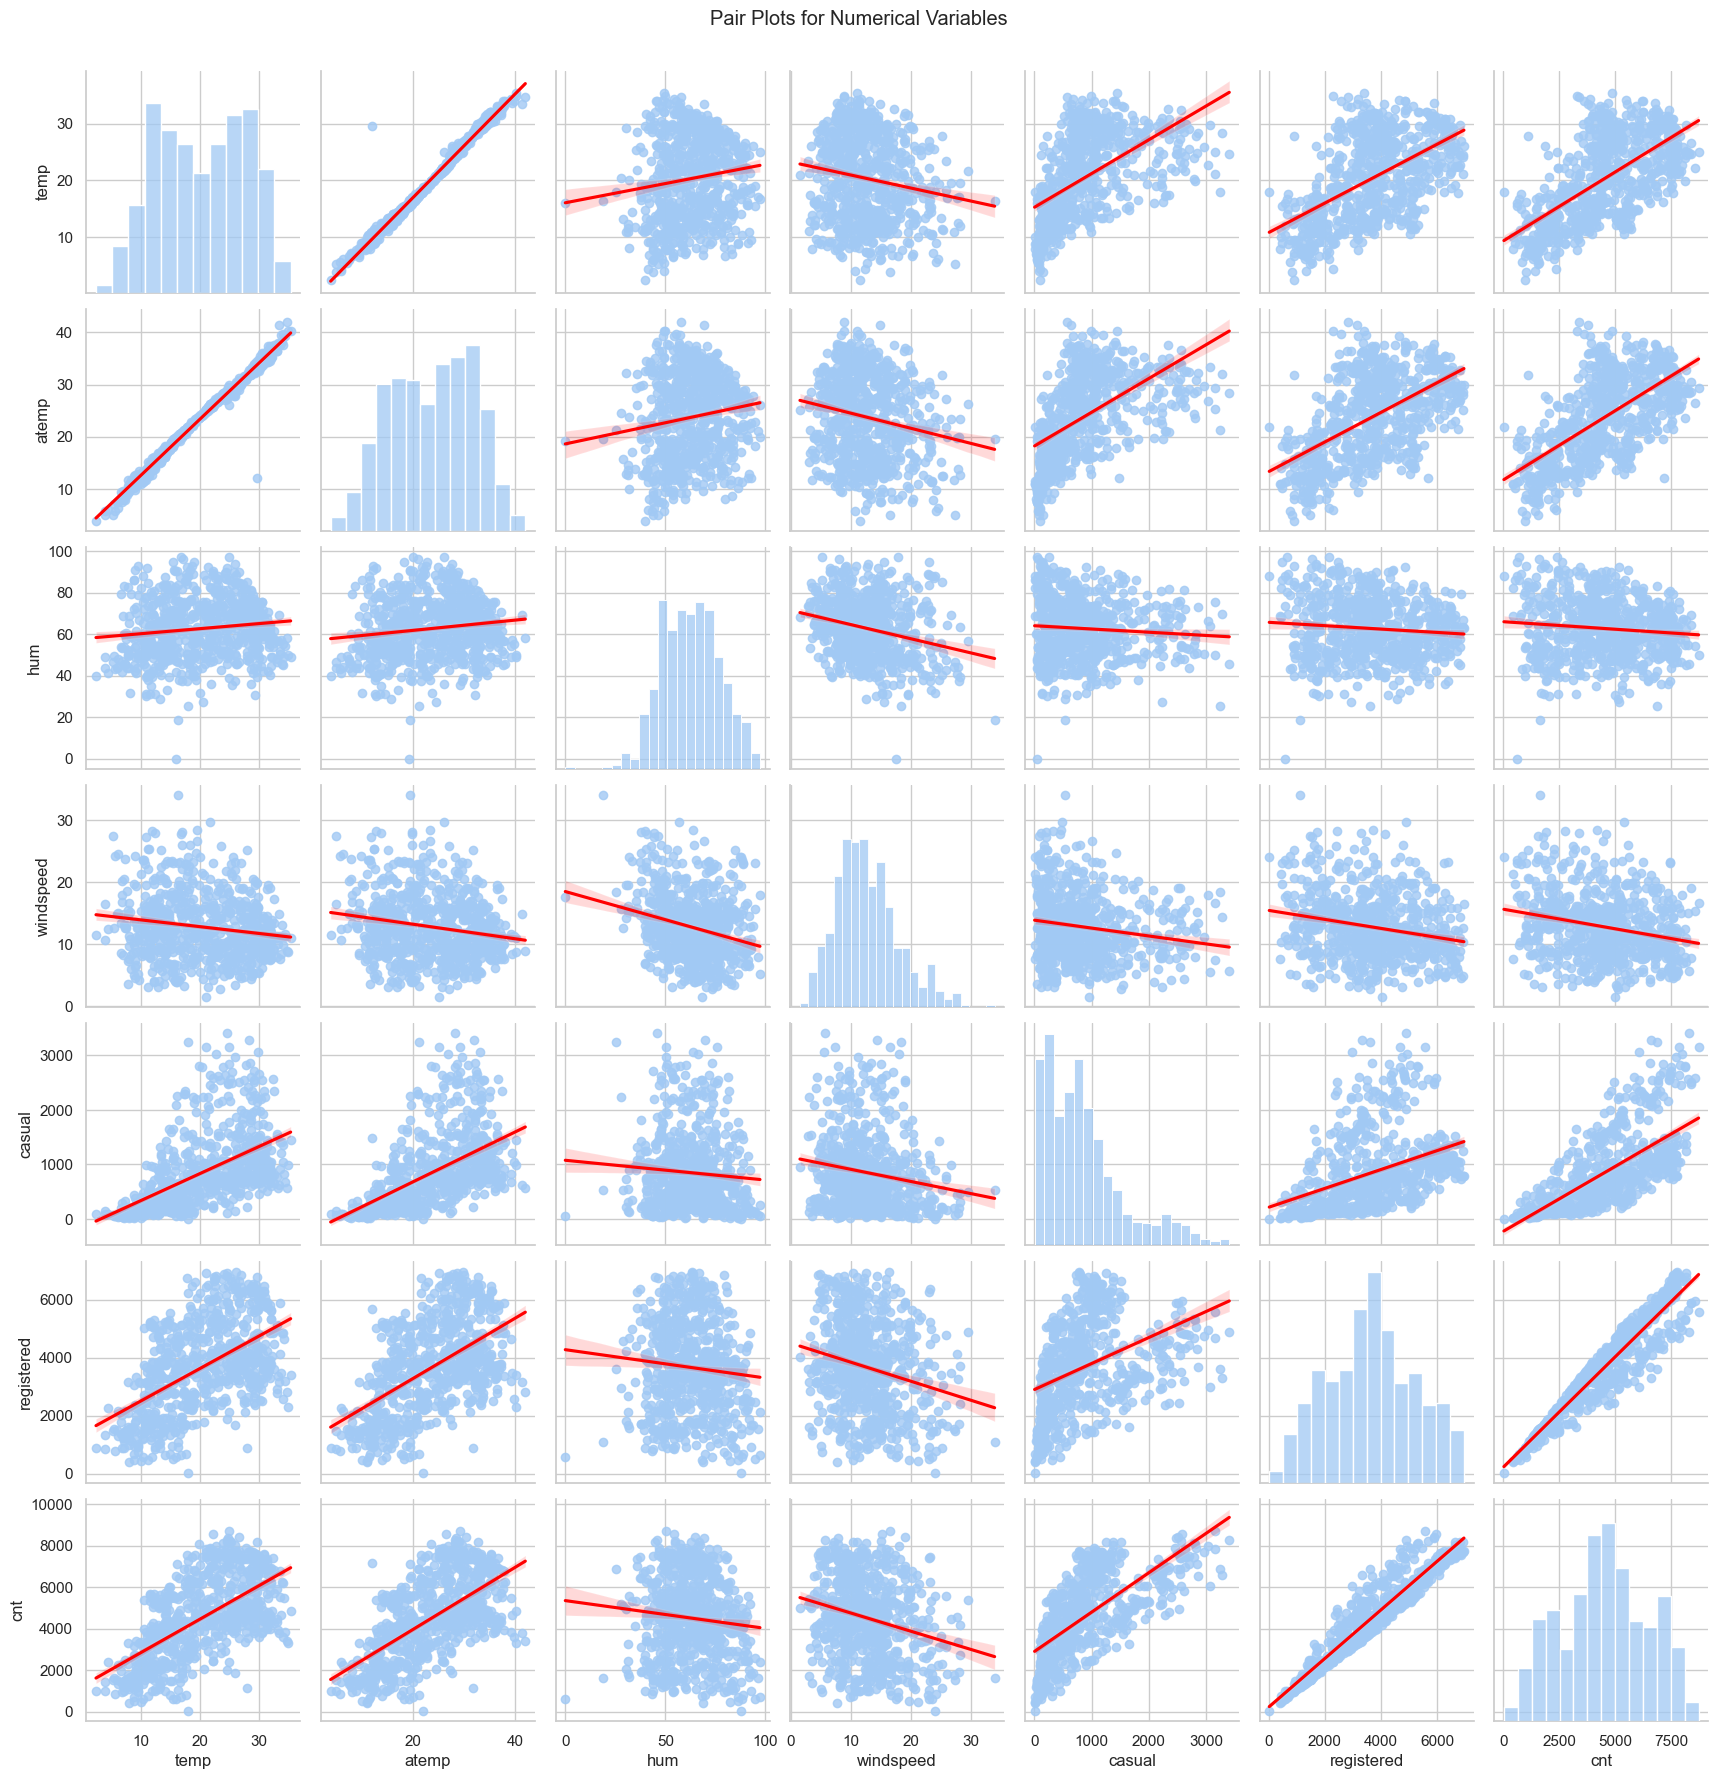

In [18]:
# Creating pair plots for numerical variables with reg
sns.pairplot(data[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'workingday']], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'red'}}
)
plt.suptitle('Pair Plots for Numerical Variables', y=1.02)
plt.show()

In [19]:
display(ct_x_by_vol(data=data, row='season', volume='cnt'))
display(ct_x_by_vol(data=data, row='yr', volume='cnt'))
display(ct_x_by_vol(data=data, row='holiday', volume='cnt'))
display(ct_x_by_vol(data=data, row='weekday', volume='cnt'))
display(ct_x_by_vol(data=data, row='workingday', volume='cnt'))
display(ct_x_by_vol(data=data, row='weathersit', volume='cnt'))

cnt  percentage
season                     
spring   469514       14.27
summer   918589       27.91
fall    1061129       32.24
winter   841613       25.57

cnt  percentage
yr                     
0   1243103       37.77
1   2047742       62.23

cnt  percentage
holiday                     
0        3212410       97.62
1          78435        2.38

cnt  percentage
weekday                      
Sunday     444027       13.49
Monday     455503       13.84
Tuesday    469109       14.25
Wednesday  471214       14.32
Thursday   485395       14.75
Friday     487790       14.82
Saturday   477807       14.52

cnt  percentage
workingday                     
0           1000269        30.4
1           2290576        69.6

cnt  percentage
weathersit                          
clear            2257952       68.61
mist/cloud        995024       30.24
light rain/snow    37869        1.15

In [20]:
display(ct_x_by_y_by_vol(data=data, row='mnth', col='season', volume='cnt'))
display(ct_x_by_y_by_vol(data=data, row='weathersit', col='season', volume='cnt'))
display(ct_x_by_y_by_vol(data=data, row='weekday', col='holiday', volume='cnt'))

season     spring  summer    fall  winter  spring_percentage  \
mnth                                                           
January    134933       0       0       0               4.10   
February   149518       0       0       0               4.54   
March      142065   86855       0       0               4.32   
April           0  269094       0       0               0.00   
May             0  331686       0       0               0.00   
June            0  230954  115388       0               0.00   
July            0       0  344948       0               0.00   
August          0       0  351194       0               0.00   
September       0       0  249599   96392               0.00   
October         0       0       0  322352               0.00   
November        0       0       0  254831               0.00   
December    42998       0       0  168038               1.31   

season     summer_percentage  fall_percentage  winter_percentage  
mnth                                                              
January                 0.00             0.00               0.00  
February                0.00             0.00               0.00  
March                   2.64             0.00               0.00  
April                   8.18             0.00               0.00  
May                    10.08             0.00               0.00  
June                    7.02             3.51               0.00  
July                    0.00            10.48               0.00  
August                  0.00            10.67               0.00  
September               0.00             7.58               2.93  
October                 0.00             0.00               9.80  
November                0.00             0.00               7.74  
December                0.00             0.00               5.11

season           spring  summer    fall  winter  spring_percentage  \
weathersit                                                           
clear            312036  626986  799443  519487               9.48   
mist/cloud       153739  288096  250679  302510               4.67   
light rain/snow    3739    3507   11007   19616               0.11   

season           summer_percentage  fall_percentage  winter_percentage  
weathersit                                                              
clear                        19.05            24.29              15.79  
mist/cloud                    8.75             7.62               9.19  
light rain/snow               0.11             0.33               0.60

holiday         0      1  0_percentage  1_percentage
weekday                                             
Sunday     444027      0         13.49          0.00
Monday     395898  59605         12.03          1.81
Tuesday    468096   1013         14.22          0.03
Wednesday  463811   7403         14.09          0.22
Thursday   481475   3920         14.63          0.12
Friday     481296   6494         14.63          0.20
Saturday   477807      0         14.52          0.00

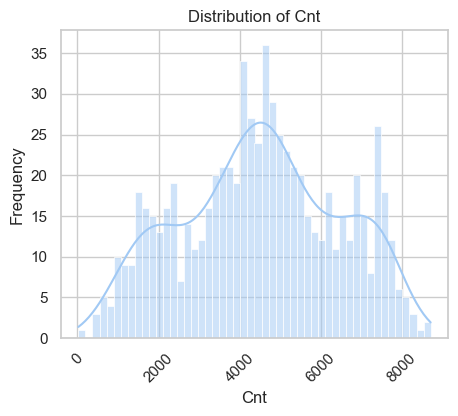

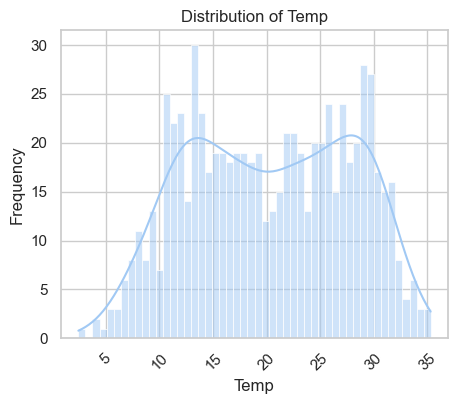

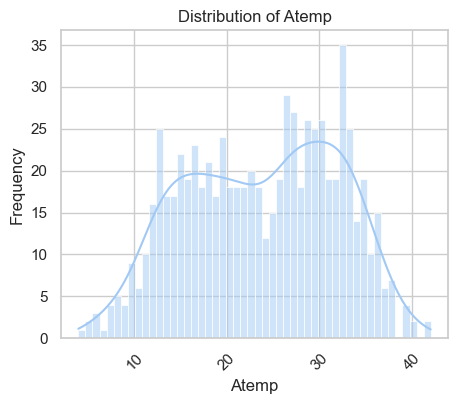

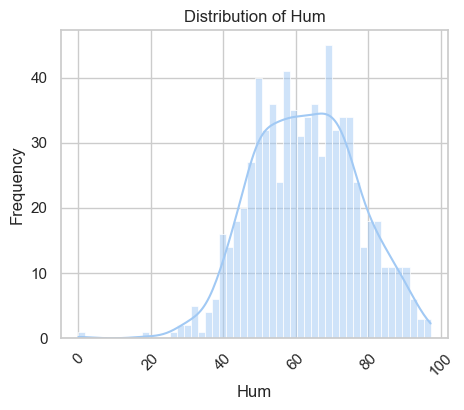

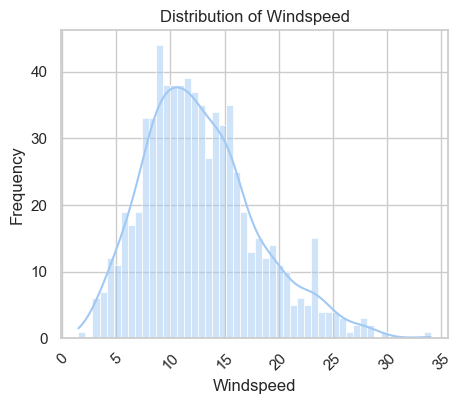

In [21]:
variables = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

# Create a histogram with KDE line for each variable
for var in variables:
    plt.figure(figsize=(5, 4))
    sns.histplot(data[var], bins=50, kde=True)
    plt.xlabel(var.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var.capitalize()}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

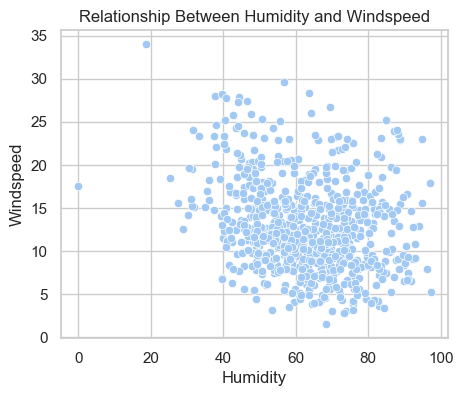

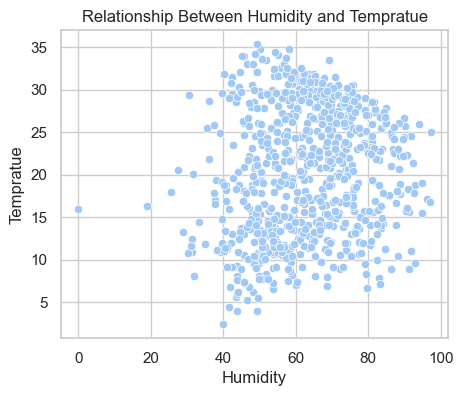

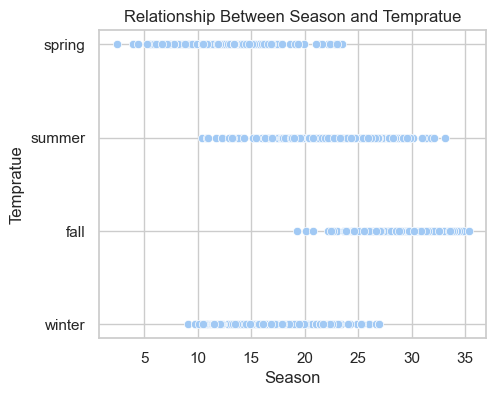

In [22]:
plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='hum', y='windspeed', alpha=1)
plt.xlabel('Humidity')
plt.ylabel('Windspeed')
plt.title('Relationship Between Humidity and Windspeed')
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='hum', y='temp', alpha=1)
plt.xlabel('Humidity')
plt.ylabel('Tempratue')
plt.title('Relationship Between Humidity and Tempratue')
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
sns.scatterplot(data=data, x='temp', y='season', alpha=1)
plt.xlabel('Season')
plt.ylabel('Tempratue')
plt.title('Relationship Between Season and Tempratue')
plt.grid(True)
plt.show()

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_and_plot_outliers(df, column):
    """
    analyze_and_plot_outliers
    -------------------------

    Calculates Z score, IQR and IsolationForest score for each column and plots it using box plot overlayed with KDE and Strip plot.
    Takes special care to ensure X and Y scale align to allow visual comparision

    """

    print(f'---- {column} ----')

    # Copy dataframe as we are not yet trying to remove data
    df = pd.DataFrame(df[column], columns=[column]).copy(deep=True)

    if df[column].std() == 0:
        df['z_score'] = 0
    else:
        df['z_score'] = np.abs(zscore(df[column]))
    df['outlier_z'] = df['z_score'] > 3

    # IQR Method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df['outlier_iqr'] = (df[column] < (Q1 - 1.5 * IQR)
                         ) | (df[column] > (Q3 + 1.5 * IQR))

    # Isolation Forest Method
    clf = IsolationForest(contamination=0.01, random_state=42)
    df['outlier_if'] = clf.fit_predict(df[[column]])
    df['outlier_if'] = df['outlier_if'] == -1

    plt.figure(figsize=(18, 6))

    outlier_methods = ['outlier_z', 'outlier_if', 'outlier_iqr']
    titles = ['Z-score Method', 'IsolationForest Method', 'IQR Method']

    for i, method in enumerate(outlier_methods):
        to_remove = df[df[method]][column].count()
        min_val = df[df[method] == False][column].min()
        med_val = df[df[method] == False][column].median()
        max_val = df[df[method] == False][column].max()

        plt.subplot(1, 3, i+1)
        sns.boxplot(data=df[df[method] == False], x=column, color='skyblue')
        # sns.swarmplot(data=df[df[method] == False], x=column, color='black', size=1)
        sns.stripplot(data=df[df[method] == False],
                      x=column, color='black', size=0.5, jitter=True)
        sns.kdeplot(data=df[df[method] == False],
                    x=column, color='orange', linewidth=2)
        plt.title(f'{column} ({titles[i]})')
        plt.xlabel(
            f'{column}\n(to_remove: {to_remove})\n(min: {min_val})\n(median: {med_val})\n(max: {max_val})')
        plt.ylabel('Density')
        plt.xscale('log')

    plt.tight_layout()
    plt.show()

---- temp ----


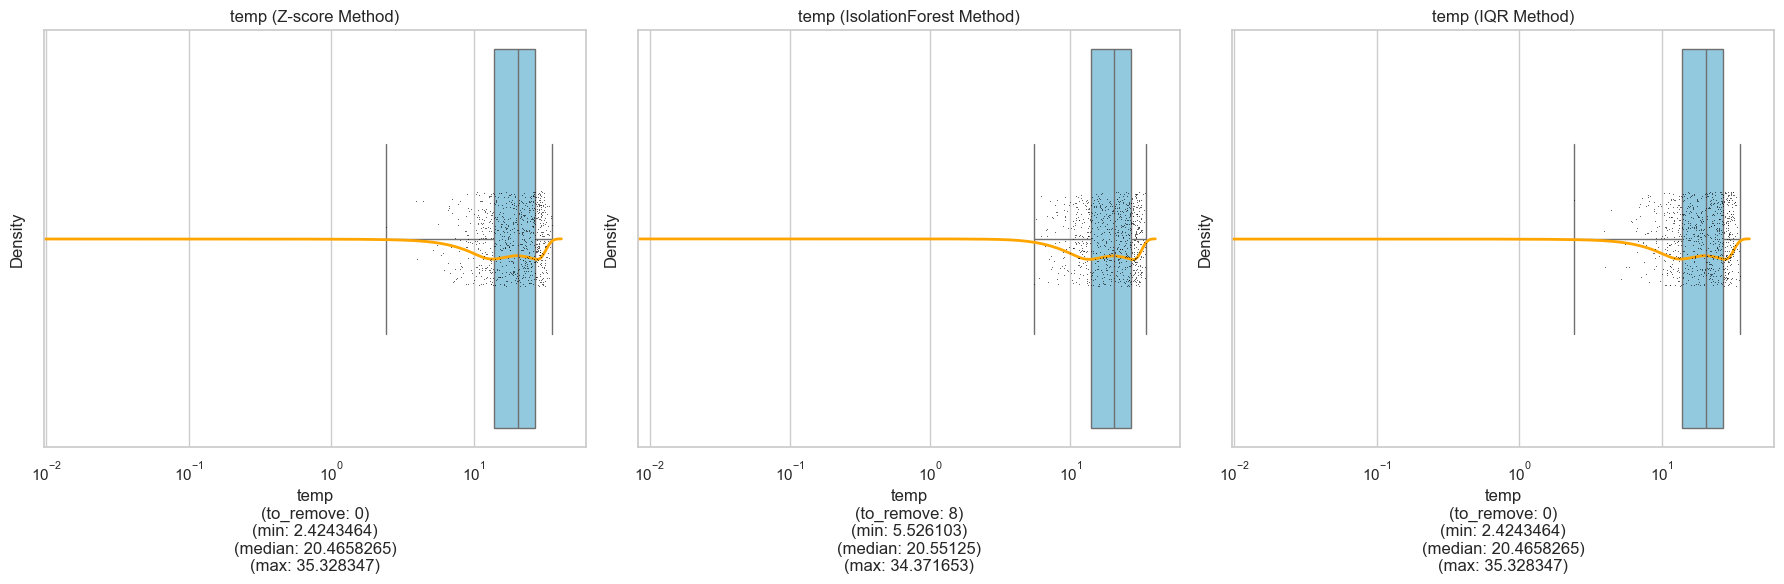

---- atemp ----


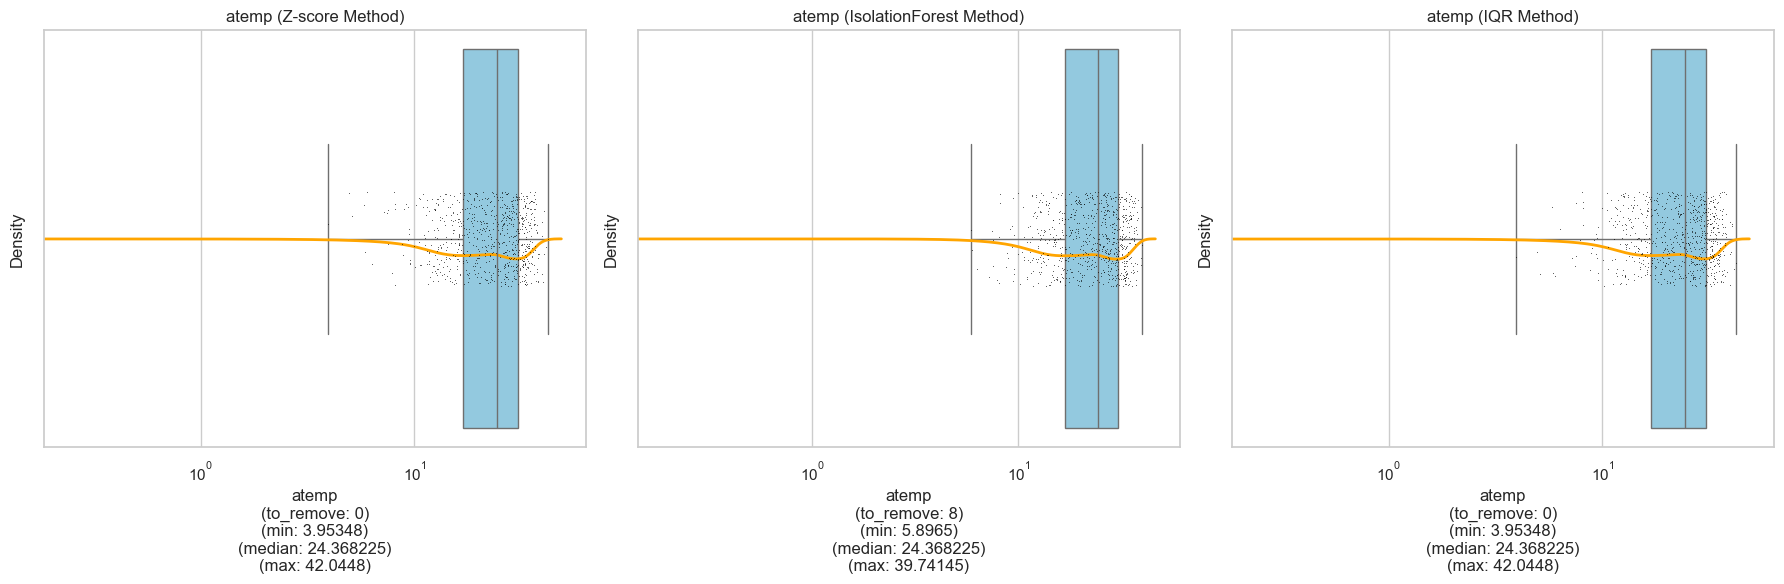

---- hum ----


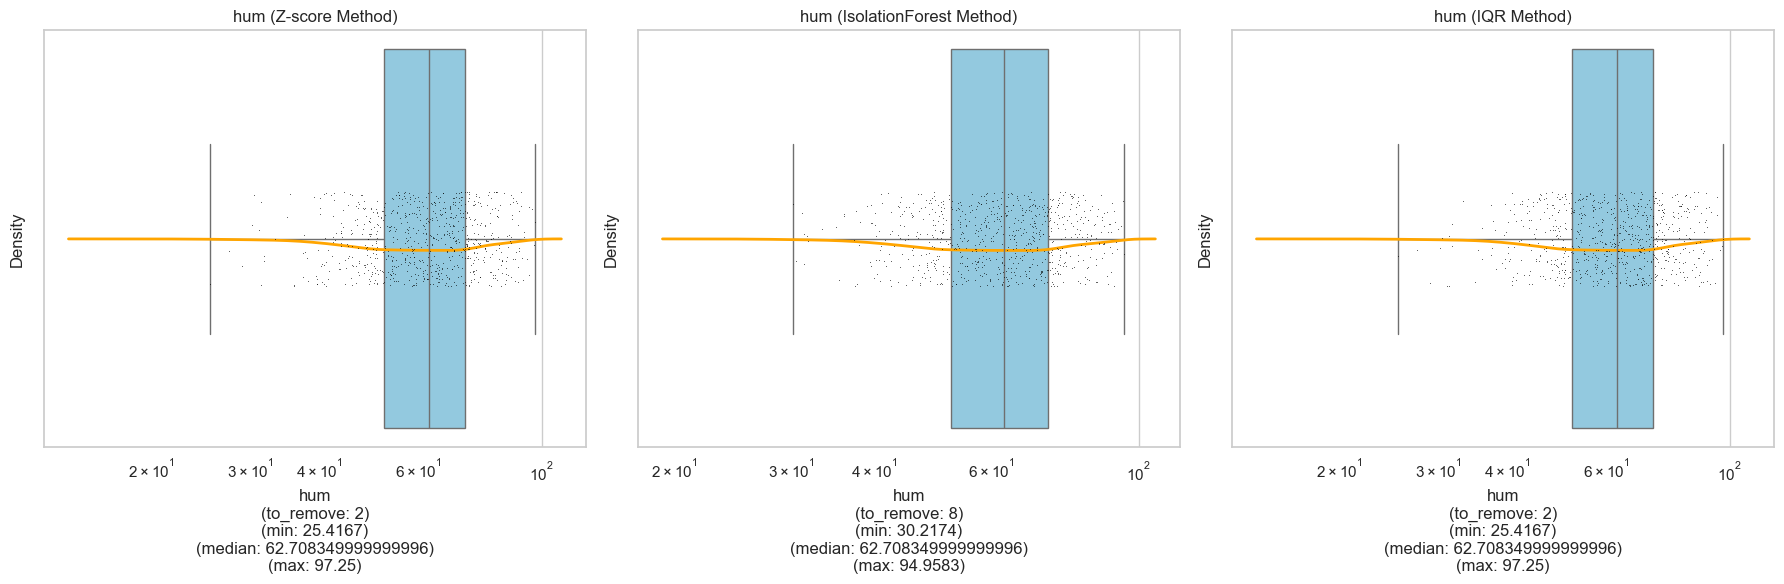

---- windspeed ----


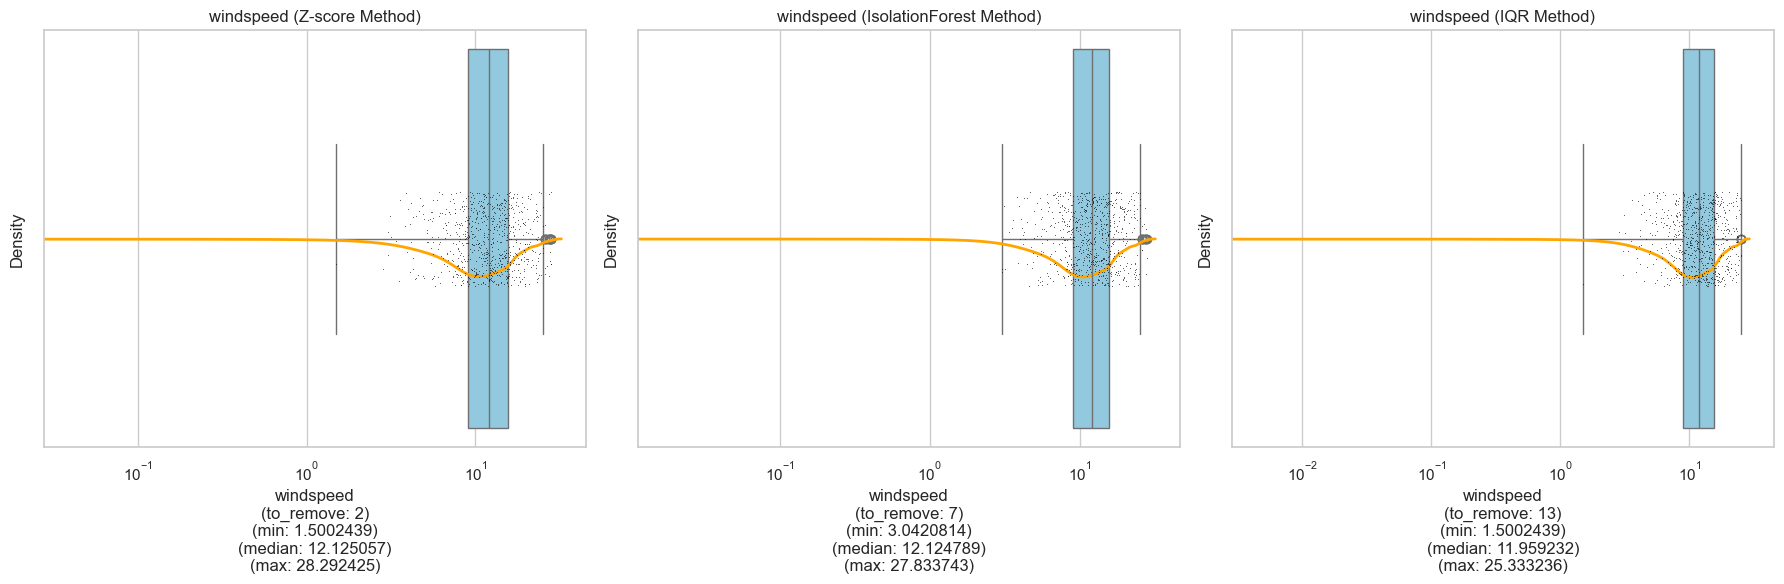

---- casual ----


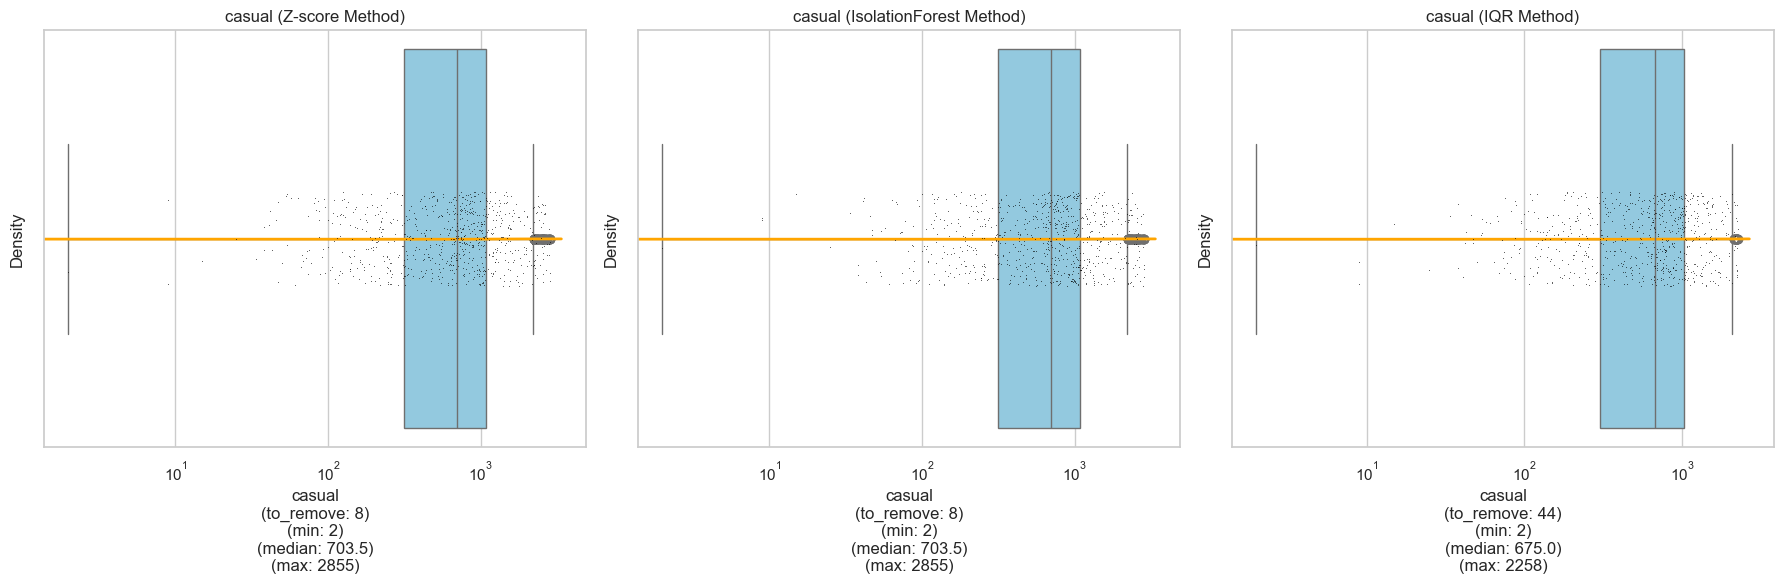

---- registered ----


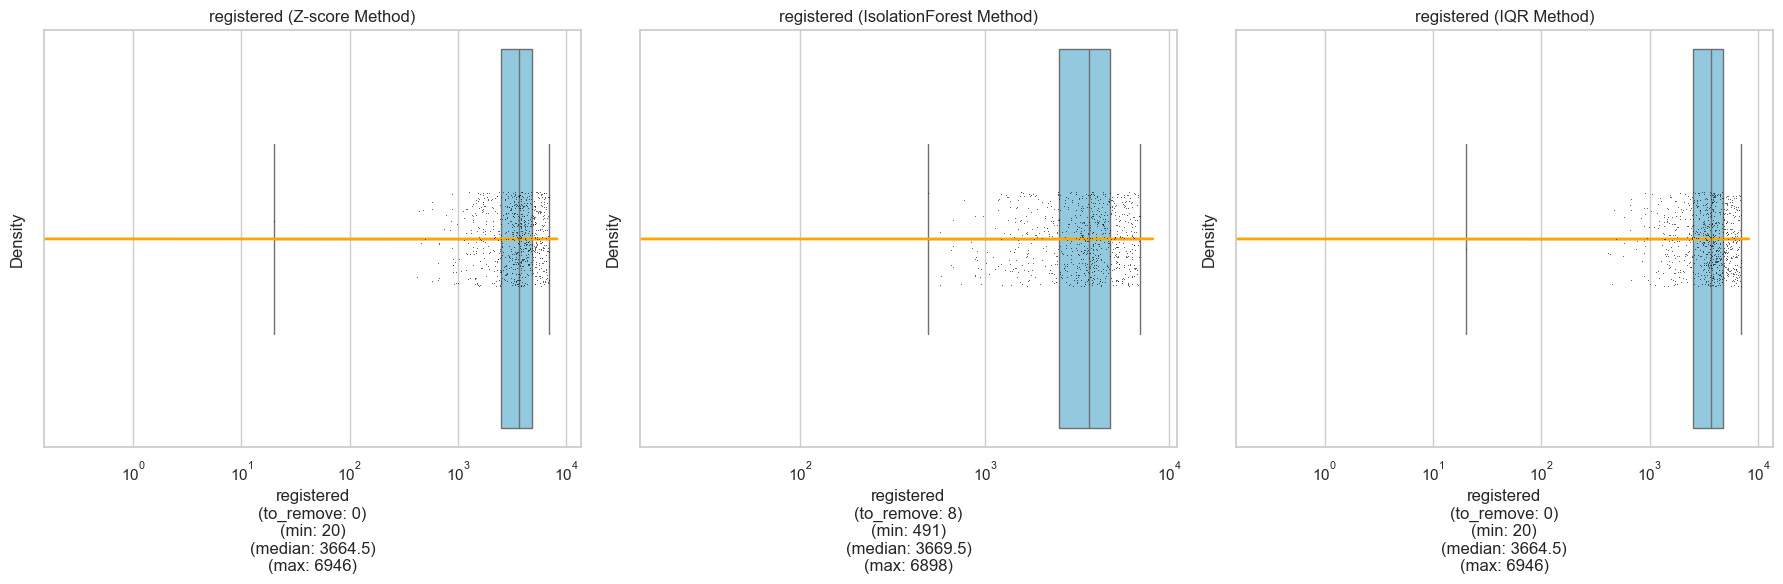

---- cnt ----


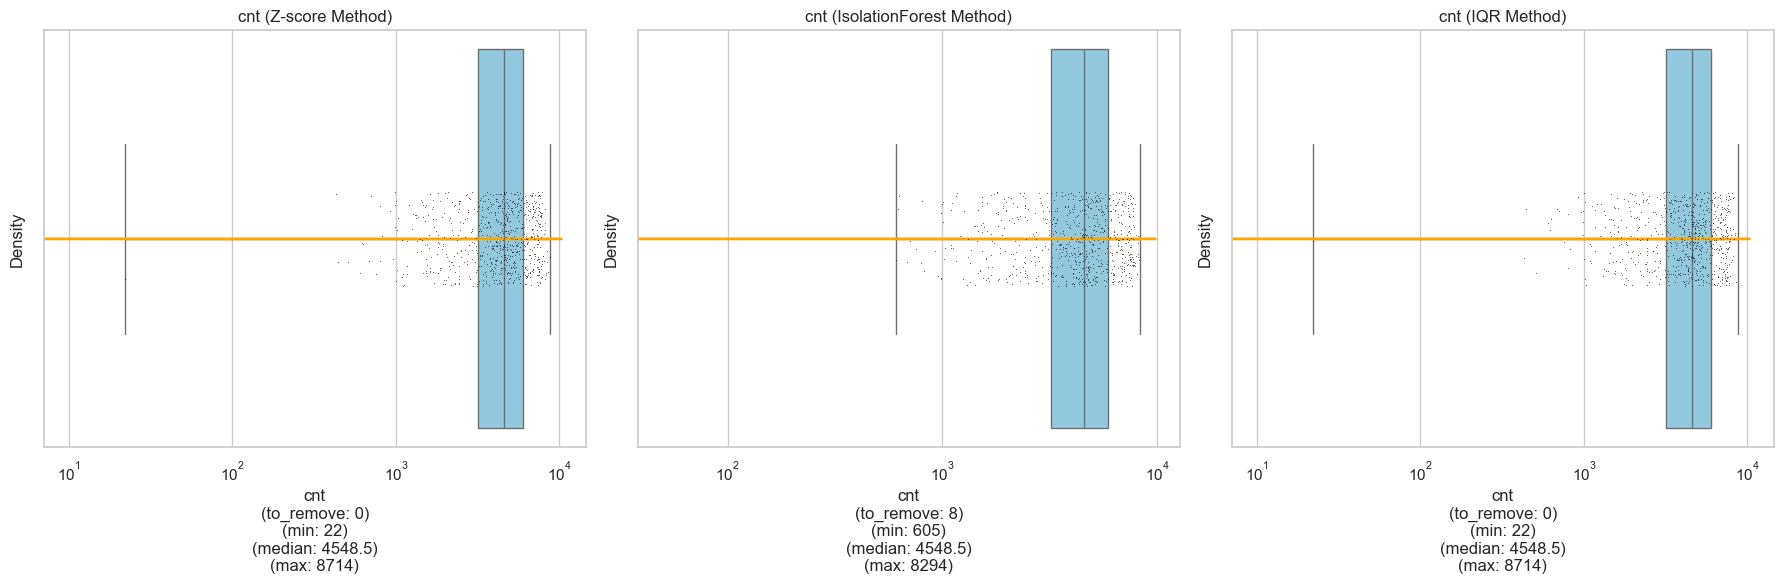

In [24]:
analyze_and_plot_outliers(data, 'temp')
analyze_and_plot_outliers(data, 'atemp')
analyze_and_plot_outliers(data, 'hum')
analyze_and_plot_outliers(data, 'windspeed')
analyze_and_plot_outliers(data, 'casual')
analyze_and_plot_outliers(data, 'registered')
analyze_and_plot_outliers(data, 'cnt')

EDA Summary

For our bike ride-sharing dataset covering the years 2018 and 2019, we analyzed various factors influencing bike rental volume (`cnt`). The EDA aimed to understand how different variables impact rental volume and identify any differences between the two years. Here are the key findings:

**Seasonal Trends (`season`)**: Rental volume is highest during the fall (32.24%) and summer (27.91%), with winter (25.57%) and spring (14.27%) showing lower volumes. Monthly breakdown shows peaks in rental volume during summer months (April, May, and June) and fall months (July, August, and September).

**Yearly Comparison (`yr`)**: There is a significant increase in rental volume from 2018 (`0`: 37.77%) to 2019 (`1`: 62.23%). This indicates a growing trend in bike rentals over time.

**Weather Conditions (`weathersit`)**: Clear weather conditions (1) are associated with the highest rental volumes (68.61%), followed by misty/cloudy (2) conditions (30.24%). Light rain/snow (3) conditions see a significant drop in volume (1.15%). Notably, there are no rental records for extreme weather conditions (4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog). This could be due to either the absence of such weather conditions in 2018 and 2019 or zero bike rentals during such conditions. However, we cannot validate this due to the `dteday` variable being dropped because it contained junk data.

**Monthly Trends (`mnth`)**: Rental volumes peak during the summer months (June, July, and August) and are lowest in winter months (December and January). Notably, June shows a transition with both summer and fall volumes being high.

**Weekday vs. Weekend (`weekday` and `workingday`)**: There is a consistent rental volume throughout the weekdays, with a slight dip on weekends. Working days (69.6%) have a higher rental volume compared to non-working days (30.4%).

**Holiday Impact (`holiday`)**: Rental volume tends to be lower on holidays (2.38%) compared to non-holidays (97.62%).

**Temperature (`temp` and `atemp`)**: There is a positive correlation between temperature and rental volume. As the temperature increases, rental volume tends to increase.

**Humidity (`hum`)**: Humidity shows a negative correlation with rental volume. Higher humidity levels are associated with lower rental volumes.

**Wind Speed (`windspeed`)**: Wind speed has a slightly negative correlation with rental volume, indicating that higher wind speeds might discourage bike rentals.

**User Type (`casual` and `registered`)**: Registered users consistently show higher rental volumes compared to casual users. Both user types show a positive correlation with overall rental volume.

**Correlation Matrix**: The correlation matrix highlights that `temp`, `atemp`, and `registered` have strong positive correlations with `cnt`. In contrast, `windspeed` and `hum` have weak negative correlations.

Final Decisions for Model Building

Based on the EDA and my latest findings, here are my final decisions for building the linear regression model to predict rental volume (`cnt`):

**Holiday (`holiday`)**: Given the small percentage of holiday data (2.38%), I will drop this variable as it may not significantly contribute to the model.

**Weather Conditions (`weathersit`)**: I will simplify the `weathersit` variable by focusing on categories 1 (clear) and 2 (mist/cloud). Since extreme weather conditions (category 4) are absent, and light rain/snow (category 3) contributes very little (1.15%) to the overall data, I will `drop these rows` entirely.

**User Type (`casual` and `registered`)**: Since `cnt` is the sum of `casual` and `registered`, these variables are inherently correlated. For the initial model, I will exclude `casual` and `registered` to avoid multicollinearity. If separate insights for different user types are desired, these variables can be included in future.

**Interaction Terms**: Based on the interaction plot between `temp` and `season`, it appears that temperature ranges differ across seasons. I will create interaction terms between `temp` and `season` to capture these seasonal variations. For example, I will create a feature for high temperatures in summer and another for low temperatures in winter.

**Temperature Groups**: Since `temp` is continuous, I will create groups or bins (e.g., low, medium, high) and then create interaction terms with `season`.

**One-Hot Encoding**: I will apply one-hot encoding to categorical variables like `season`, `weekday`, and `weathersit` (after simplifying it as mentioned above).

**Standardization**: I will use `MinMaxScaler` to standardize numerical variables (`temp`, `atemp`, `hum`, `windspeed`). This method scales the data to a range of 0 to 1, which is suitable given the distributions observed in the histograms.

**No Transformation Needed for `cnt`**: The histogram of `cnt` indicates that it is not highly skewed, so no further transformation is necessary for normalizing this variable.

**Temperature Variables**: Due to the high correlation between `temp` and `atemp` (0.99), I will include only one of these variables in the model to avoid multicollinearity issues. Based on the plots, `temp` will be preferred due to its direct measurement.

**Checking Model Assumptions**: After building the initial model, I will check for assumptions of linear regression, such as linearity, homoscedasticity, independence, and normality of residuals. Adjustments may be needed based on these diagnostics.

**Outliers**: We have `very few outliers`, we will tackle these on training dataset if required. For now we will do nothing about `outliers`

#### 5: Data Preparation

In [25]:
data.head()

instant  season yr     mnth holiday    weekday workingday  weathersit  \
0        1  spring  0  January       0   Saturday          0  mist/cloud   
1        2  spring  0  January       0     Sunday          0  mist/cloud   
2        3  spring  0  January       0     Monday          1       clear   
3        4  spring  0  January       0    Tuesday          1       clear   
4        5  spring  0  January       0  Wednesday          1       clear   

        temp     atemp      hum  windspeed  casual  registered   cnt  
0  14.110847  18.18125  80.5833  10.749882     331         654   985  
1  14.902598  17.68695  69.6087  16.652113     131         670   801  
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349  
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562  
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600

- Varibles to drop : 'holiday', atemp, casual, registered
- Drop rows based on weathersit. Adjust categories for weathersit
- One hot encoding for  season, weekday, weathersit
- Standardize - `temp`, `hum`, `windspeed`
- Based on the distribution of `temp` from the histogram new variable temp_range, 
    - **Low Temperature**:  < 15°C
    - **Medium Temperature**: 15°C to 25°C
    - **High Temperature**: > 25°C

In [26]:
data = data.drop(columns=['holiday', 'atemp', 'casual', 'registered', 'instant'])

In [27]:
print (data.shape)
data = data[data['weathersit'].isin(['mist/cloud', 'clear'])]
data['weathersit'] = data['weathersit'].cat.remove_unused_categories()
print (data.shape)

(730, 10)
(709, 10)


We are retaining following variables as-is and converting to numerical

In [28]:
data[['workingday', 'yr']] = data[['workingday', 'yr']].astype(int)   # These are already encoded as 0 and 1.

In [29]:
def fnc(temp):
    if temp < 15:
        return 'Low'
    elif 15 <= temp <= 25:
        return 'Medium'
    else:
        return 'High'

data['temp_range'] = data['temp'].apply(fnc)
data['season_temp'] = data['season'].astype(str) + '_' + data['temp_range']

In [30]:
# Checking for invalid data entries in categorical variables
unique_vals = {
    'season': data['season'].unique(),
    'yr': data['yr'].unique(),
    'mnth': data['mnth'].unique(),
    'weekday': data['weekday'].unique(),
    'workingday': data['workingday'].unique(),
    'weathersit': data['weathersit'].unique(),
    'temp_range': data['temp_range'].unique(),
    'season_temp': data['season_temp'].unique()
}
unique_vals

{'season': ['spring', 'summer', 'fall', 'winter']
 Categories (4, object): ['spring', 'summer', 'fall', 'winter'],
 'yr': array([0, 1]),
 'mnth': ['January', 'February', 'March', 'April', 'May', ..., 'August', 'September', 'October', 'November', 'December']
 Length: 12
 Categories (12, object): ['January', 'February', 'March', 'April', ..., 'September', 'October', 'November', 'December'],
 'weekday': ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
 Categories (7, object): ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
 'workingday': array([0, 1]),
 'weathersit': ['mist/cloud', 'clear']
 Categories (2, object): ['clear', 'mist/cloud'],
 'temp_range': array(['Low', 'Medium', 'High'], dtype=object),
 'season_temp': array(['spring_Low', 'spring_Medium', 'summer_Medium', 'summer_Low',
        'summer_High', 'fall_High', 'fall_Medium', 'winter_Medium',
        'winter_High', 'winter_Low'], dtype=object)}

In [31]:
data.head(n=10)

season  yr     mnth    weekday  workingday  weathersit       temp      hum  \
0  spring   0  January   Saturday           0  mist/cloud  14.110847  80.5833   
1  spring   0  January     Sunday           0  mist/cloud  14.902598  69.6087   
2  spring   0  January     Monday           1       clear   8.050924  43.7273   
3  spring   0  January    Tuesday           1       clear   8.200000  59.0435   
4  spring   0  January  Wednesday           1       clear   9.305237  43.6957   
5  spring   0  January   Thursday           1       clear   8.378268  51.8261   
6  spring   0  January     Friday           1  mist/cloud   8.057402  49.8696   
7  spring   0  January   Saturday           0  mist/cloud   6.765000  53.5833   
8  spring   0  January     Sunday           0       clear   5.671653  43.4167   
9  spring   0  January     Monday           1       clear   6.184153  48.2917   

   windspeed   cnt temp_range season_temp  
0  10.749882   985        Low  spring_Low  
1  16.652113   801        Low  spring_Low  
2  16.636703  1349        Low  spring_Low  
3  10.739832  1562        Low  spring_Low  
4  12.522300  1600        Low  spring_Low  
5   6.000868  1606        Low  spring_Low  
6  11.304642  1510        Low  spring_Low  
7  17.875868   959        Low  spring_Low  
8  24.250650   822        Low  spring_Low  
9  14.958889  1321        Low  spring_Low

We'll convert the categorical variables into dummy variables using one-hot encoding.


In [32]:
categorical_vars = ['season', 'mnth', 'weekday', 'weathersit', 'temp_range', 'season_temp']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype=int)

In [33]:
data.head()

yr  workingday       temp      hum  windspeed   cnt  season_summer  \
0   0           0  14.110847  80.5833  10.749882   985              0   
1   0           0  14.902598  69.6087  16.652113   801              0   
2   0           1   8.050924  43.7273  16.636703  1349              0   
3   0           1   8.200000  59.0435  10.739832  1562              0   
4   0           1   9.305237  43.6957  12.522300  1600              0   

   season_fall  season_winter  mnth_February  mnth_March  mnth_April  \
0            0              0              0           0           0   
1            0              0              0           0           0   
2            0              0              0           0           0   
3            0              0              0           0           0   
4            0              0              0           0           0   

   mnth_May  mnth_June  mnth_July  mnth_August  mnth_September  mnth_October  \
0         0          0          0            0               0             0   
1         0          0          0            0               0             0   
2         0          0          0            0               0             0   
3         0          0          0            0               0             0   
4         0          0          0            0               0             0   

   mnth_November  mnth_December  weekday_Monday  weekday_Tuesday  \
0              0              0               0                0   
1              0              0               0                0   
2              0              0               1                0   
3              0              0               0                1   
4              0              0               0                0   

   weekday_Wednesday  weekday_Thursday  weekday_Friday  weekday_Saturday  \
0                  0                 0               0                 1   
1                  0                 0               0                 0   
2                  0                 0               0                 0   
3                  0                 0               0                 0   
4                  1                 0               0                 0   

   weathersit_mist/cloud  temp_range_Low  temp_range_Medium  \
0                      1               1                  0   
1                      1               1                  0   
2                      0               1                  0   
3                      0               1                  0   
4                      0               1                  0   

   season_temp_fall_Medium  season_temp_spring_Low  season_temp_spring_Medium  \
0                        0                       1                          0   
1                        0                       1                          0   
2                        0                       1                          0   
3                        0                       1                          0   
4                        0                       1                          0   

   season_temp_summer_High  season_temp_summer_Low  season_temp_summer_Medium  \
0                        0                       0                          0   
1                        0                       0                          0   
2                        0                       0                          0   
3                        0                       0                          0   
4                        0                       0                          0   

   season_temp_winter_High  season_temp_winter_Low  season_temp_winter_Medium  
0                        0                       0                          0  
1                        0                       0                          0  
2                        0                       0                          0  
3                        0                       0                          0  
4                        0     

In [34]:
data.shape

(709, 38)


#### 6. **Model Building**

##### Train-Test Split - We'll split the dataset into training and testing sets.

Reviewing the histogram of `cnt` the distribution is relatively symmetrical with a slight right skew, and it covers a wide range of values. Given this, stratified sampling is not necessary. We will use simple random split of 70:30.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [36]:
def train_and_evaluate_sm(y, X, limit: float = 0.05) -> any:
    """
    train_and_evaluate_sm
    ---------------------

    print OLS summary
    Returns model and variable with highest p-value if it is higher than the limit, otherwise "None"
    """
    model = sm.OLS(y, sm.add_constant(X)).fit()
    p_values = model.pvalues.drop('const')
    max_p_value = p_values.max()
    var = p_values.idxmax() if max_p_value > limit else None
    
    print(model.summary())
    return model, var

    
def train_and_evaluate_sk(X_train, y_train, X_test, y_test) -> any:
    """
    train_and_evaluate sklearn LinearRegression() 
    """
    # Initialize the linear regression model
    model = LinearRegression()

    # Fit the model on the scaled training data
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(X_train)

    # Make predictions on the test set
    y_test_pred = model.predict(X_test)

    # Calculate the performance metrics
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    predictions = {
            "train": y_train_pred,
            "test": y_test_pred
        }

    p = {
            "train_rmse": round(float(train_rmse),3),
            "test_rmse": round(float(test_rmse),3),
            "train_r2": round(float(train_r2),3),
            "test_r2": round(float(test_r2),3)
        }

    print (p)

    return model, predictions

def calculate_vif(X: pd.DataFrame, limit : float = 5) -> any:
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame X.
    """
    X = sm.add_constant(X).copy(deep=True)
    
    VIF_data = pd.DataFrame()
    VIF_data["Feature"] = X.columns
    VIF_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop the constant column from the results
    VIF_data = VIF_data.drop(VIF_data[VIF_data['Feature'] == 'const'].index)
    
    # Identify the variable with the highest VIF
    max_vif_value = VIF_data["VIF"].max()
    feature_with_max_VIF = VIF_data.loc[VIF_data["VIF"].idxmax(), "Feature"] if max_vif_value > limit else None
    
    print(VIF_data.sort_values(by='VIF',ascending=False))

    return VIF_data, feature_with_max_VIF

In [37]:
X = data.drop(columns=['cnt'])      # Predictors 
y = data['cnt']                     # Targets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((496, 37), (213, 37), (496,), (213,))

In [38]:
scaler = MinMaxScaler()

cols = ['temp', 'hum', 'windspeed']

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [39]:
data[cols].describe(include='all')

temp         hum   windspeed
count  709.000000  709.000000  709.000000
mean    20.394735   62.109937   12.658772
std      7.550053   13.501781    5.145185
min      2.424346   18.791700    1.500244
25%     13.803347   51.826100    9.000579
50%     20.642598   62.208300   12.000236
75%     26.957500   72.000000   15.478139
max     35.328347   97.250000   34.000021

In [40]:
X_train[cols].describe(include='all')

temp         hum   windspeed
count  496.000000  496.000000  496.000000
mean     0.553079    0.557641    0.344286
std      0.227733    0.168004    0.163780
min      0.000000    0.000000    0.000000
25%      0.353092    0.428438    0.229498
50%      0.564921    0.565056    0.313468
75%      0.746117    0.688131    0.433540
max      1.000000    1.000000    1.000000

In [41]:
X_test[cols].describe(include='all')

temp         hum   windspeed
count  213.000000  213.000000  213.000000
mean     0.530002    0.539256    0.341143
std      0.233163    0.180999    0.145135
min      0.060271    0.084440    0.051298
25%      0.322791    0.403080    0.234647
50%      0.504695    0.530005    0.338446
75%      0.745598    0.668198    0.426921
max      0.984424    0.969106    0.815378

In [42]:
models_sk = {} # We will store all models in a dictionary. 
models_sm = {} # We will store all models in a dictionary. 

##### Model 0

In [43]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
models_sk['model0'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train, limit=0.05)
models_sm['model0'] = model2

print (f'Variable to remove : {to_remove}')

{'train_rmse': 699.273, 'test_rmse': 754.254, 'train_r2': 0.858, 'test_r2': 0.854}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     87.36
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          2.48e-174
Time:                        09:37:08   Log-Likelihood:                -3952.6
No. Observations:                 496   AIC:                             7971.
Df Residuals:                     463   BIC:                             8110.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

Summary of `first regression model` with all variables.


**Performance Summary Review**

1. **Model Performance Metrics**:
   - **Training RMSE**: 699.273
   - **Testing RMSE**: 754.254
   - **Training R squared**: 0.858
   - **Testing R squared**: 0.854

The model explains about `85.8%` of the variance in the training set and `85.4%` in the testing set, indicating a good fit. The RMSE values for both training and testing are relatively close, suggesting that the model generalizes well to unseen data without significant overfitting.

2. **Regression Coefficients**:
   - Several variables are significant predictors of `cnt`, including `yr`, `temp`, `hum`, `windspeed`, `season_summer`, `season_fall`, `season_winter`, `mnth_March`, `mnth_May`, etc., with p-values less than 0.05.
   - Some variables, such as `weekday_Tuesday`, `weekday_Wednesday`, `mnth_November`, `mnth_December`, `weekday_Monday`, `weekday_Thursday`, `weekday_Friday`, `mnth_July`, are not significant, with p-values greater than 0.05, suggesting they do not contribute much to the model.

3. **Multicollinearity**:
   - The note about the smallest eigenvalue (1.13e-29) suggests potential multicollinearity problems or that the design matrix may be singular. This can cause instability in the coefficient estimates.

4. **Distribution of Residuals**:
   - The Omnibus test and Jarque-Bera test indicate that the residuals are not normally distributed (`Prob(Omnibus)` and `Prob(JB)` are both 0.000). Skewness is -0.725, indicating a slight negative skew, and kurtosis is 5.197, indicating heavier tails than a normal distribution.

**Interpretation**
- The high R squared values for both training and testing sets show that the model captures a large proportion of the variance in the data, suggesting good predictive performance.
- The close RMSE values for training and testing indicate that the model does not suffer from significant overfitting or underfitting.
- Variables such as `yr`, `temp`, `hum`, `windspeed`, and specific seasons and months are significant predictors of bike rental counts. This aligns with the expected influence of these factors on bike rentals.
- Interaction terms involving temperature and seasons also show significance, which supports the decision to include these terms in the model.
- The potential multicollinearity issue indicated by the smallest eigenvalue needs to be addressed. This can be done by checking the Variance Inflation Factor (VIF) for each predictor and potentially removing or combining highly correlated predictors.
- The non-normality of residuals suggests that the model might benefit from further refinement, such as addressing outliers or transforming some of the predictors.

Next Steps

I will iteratively remove variables with high p-values until all remaining variables have acceptable p-values (typically less than 0.05). This process will help simplify the model and potentially improve its performance by removing non-significant predictors. After addressing the p-values, I will also check for multicollinearity and ensure that the model assumptions are met.

##### Model A

- I will drop columns based on `p-values` one by one.
- I am not focused on how many variables it removes and only focused on variables it keeps at the end.
- We can review summmary OLS summary printed at each stage starting from last summary, if any concerns with last model generated by this process. 

In [44]:
t = to_remove
to_drop = []

while t is not None:
    print ('=============================================================================================')
    print (f'After removing : {t}')
    print ('=============================================================================================')
    print()
    print()
    to_drop.append(t)
    to_keep = [v for v in X_train.columns if v not in to_drop]

    _, t = train_and_evaluate_sm(y=y_train, X=X_train[to_keep], limit=0.05)
    print ('=============================================================================================')


After removing : weekday_Tuesday


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     90.37
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          2.61e-175
Time:                        09:37:08   Log-Likelihood:                -3952.6
No. Observations:                 496   AIC:                             7969.
Df Residuals:                     464   BIC:                             8104.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

**Post iterative removal of variables based on p-value we are left with following**

```python 
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [45]:
to_keep

['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [46]:
# to_keep = [v for v in X_train.columns if v not in to_drop]
to_keep = to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_fall',
 'season_winter',
 'mnth_March',
 'mnth_May',
 'mnth_June',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium',
 'season_temp_summer_High',
 'season_temp_winter_High']

In [47]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train[to_keep],
    y_train=y_train,
    X_test=X_test[to_keep],
    y_test=y_test
)
models_sk['modelA'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train[to_keep], limit=0.05)
models_sm['modelA'] = model2

print (f'Variable to remove : {to_remove}')

{'train_rmse': 709.956, 'test_rmse': 767.722, 'train_r2': 0.854, 'test_r2': 0.849}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     146.0
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          1.14e-184
Time:                        09:37:09   Log-Likelihood:                -3960.1
No. Observations:                 496   AIC:                             7960.
Df Residuals:                     476   BIC:                             8044.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

1. **Model Performance Metrics**:
   - **Training RMSE**: 709.956
   - **Testing RMSE**: 767.722
   - **Training R squared**: 0.854
   - **Testing R squared**: 0.849

   The model explains about 85.4% of the variance in the training set and 84.9% in the testing set, indicating a good fit. The RMSE values for both training and testing are relatively close, suggesting that the model generalizes well to unseen data without significant overfitting.

2. **Regression Coefficients**:
   - All remaining variables are significant predictors of `cnt`, with p-values less than 0.05.
   - Key significant variables include `yr`, `temp`, `hum`, `windspeed`, `season_summer`, `season_fall`, `season_winter`, `mnth_March`, `mnth_May`, `mnth_June`, `mnth_August`, `mnth_September`, `mnth_October`, `weekday_Saturday`, `weathersit_mist/cloud`, `temp_range_Medium`, `season_temp_summer_High`, and `season_temp_winter_High`.

3. **Multicollinearity**:
   - The condition number (30.3) is significantly lower than the previous model's, suggesting that multicollinearity has been reduced.
   - No additional warnings about multicollinearity or singularity in the design matrix.

4. **Distribution of Residuals**:
   - The Omnibus test and Jarque-Bera test indicate that the residuals are not normally distributed (`Prob(Omnibus)` and `Prob(JB)` are both 0.000). Skewness is -0.716, indicating a slight negative skew, and kurtosis is 5.100, indicating heavier tails than a normal distribution.

5. The significant predictors align with expectations, such as `yr`, `temp`, `hum`, `windspeed`, and specific `seasons` and `months`, which influence bike rental counts.

Next Steps
1. **Check Multicollinearity**:
   - Calculate the Variance Inflation Factor (VIF) for each remaining predictor to ensure multicollinearity is within acceptable limits.
   - If any predictor has a high VIF, consider further refinement.

2. **Residual Diagnostics**:
   - Investigate the residuals for patterns that might suggest model improvements, such as non-linearity or heteroscedasticity.
   - Consider transforming some predictors or adding polynomial terms if necessary.

3. **Validation**:
   - Perform cross-validation to ensure the robustness of the model and validate its performance further.

##### Model B 

- We will check `multicollinearity` using `VIF(Variance Inflation Factor)` and rebuild model
- At every stage we will remove variables with high `p-value` one by one till all `p-values` are below threshold, and re-run VIF checks

In [48]:
_, to_remove = calculate_vif(X=X_train[to_keep])
print (f'Variable to remove based on highest VIF : {to_remove}')

                    Feature        VIF
7               season_fall  12.283978
3                      temp   7.821205
18  season_temp_summer_High   3.928120
6             season_summer   3.404734
17        temp_range_Medium   2.886459
8             season_winter   2.510750
10                 mnth_May   1.962230
4                       hum   1.961544
13           mnth_September   1.940118
19  season_temp_winter_High   1.875804
11                mnth_June   1.710334
14             mnth_October   1.678262
16    weathersit_mist/cloud   1.642738
12              mnth_August   1.631246
2                workingday   1.524325
15         weekday_Saturday   1.494698
9                mnth_March   1.232530
5                 windspeed   1.212250
1                        yr   1.051806
Variable to remove based on highest VIF : season_fall


VIF Summary and Actions

- **Remove `season_fall`**: VIF of 12.283978 indicates significant multicollinearity.
- **Rebuild the model**: Evaluate the OLS summary and VIF values after removing `season_fall`.
- **Recheck `temp`**: Initially high VIF of 7.821205; reassess after removing `season_fall`.
- **Ensure model performance**: Maintain strong R sqaure and RMSE values while addressing multicollinearity.

In [49]:
t = to_remove
to_drop = []

while t is not None:
    print ('=============================================================================================')
    print (f'After removing : {t}')
    print ('=============================================================================================')
    print()
    print()
    to_drop.append(t)
    to_keep = [v for v in X_train[to_keep].columns if v not in to_drop]

    _, t = train_and_evaluate_sm(y=y_train, X=X_train[to_keep], limit=0.05)
    print ('=============================================================================================')


After removing : season_fall


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     141.5
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          3.80e-178
Time:                        09:37:10   Log-Likelihood:                -3978.5
No. Observations:                 496   AIC:                             7995.
Df Residuals:                     477   BIC:                             8075.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [50]:
_, to_remove = calculate_vif(X=X_train[to_keep])
print (f'Variable to remove : {to_remove}')

                  Feature       VIF
7           season_winter  1.850426
4                     hum  1.831331
11           mnth_October  1.643828
13  weathersit_mist/cloud  1.593811
6           season_summer  1.566553
2              workingday  1.501152
12       weekday_Saturday  1.493192
3                    temp  1.480222
14      temp_range_Medium  1.394115
9             mnth_August  1.362728
10         mnth_September  1.277617
5               windspeed  1.189651
8              mnth_March  1.137209
1                      yr  1.027836
Variable to remove : None


Latest VIF is < 2 for all variables, we can accept this model.

We have iteratively removed variables with high p-value and and our latest `variables to keep` are as follow

```python
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']



In [51]:
len(to_keep), to_keep

(14,
 ['yr',
  'workingday',
  'temp',
  'hum',
  'windspeed',
  'season_summer',
  'season_winter',
  'mnth_March',
  'mnth_August',
  'mnth_September',
  'mnth_October',
  'weekday_Saturday',
  'weathersit_mist/cloud',
  'temp_range_Medium'])

In [52]:
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']

In [53]:
model1, _ = train_and_evaluate_sk(
    X_train=X_train[to_keep],
    y_train=y_train,
    X_test=X_test[to_keep],
    y_test=y_test
)
models_sk['modelB'] = model1

model2, to_remove = train_and_evaluate_sm(y=y_train, X=X_train[to_keep], limit=0.05)
models_sm['modelB'] = model2

print (f'Variable to remove : {to_remove}')

{'train_rmse': 741.872, 'test_rmse': 776.169, 'train_r2': 0.84, 'test_r2': 0.845}
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     180.5
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          3.61e-181
Time:                        09:37:10   Log-Likelihood:                -3981.9
No. Observations:                 496   AIC:                             7994.
Df Residuals:                     481   BIC:                             8057.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

**Model B is my Final model**

1. **Model Performance Metrics**:
   - **Training RMSE**: 741.872
   - **Testing RMSE**: 776.169
   - **Training R squared**: 0.84
   - **Testing R squared**: 0.845

The model explains about 84% of the variance in the training set and 84.5% in the testing set, indicating a good fit. The RMSE values for both training and testing are relatively close, suggesting that the model generalizes well to unseen data without significant overfitting.

2. **Regression Coefficients**:
   - All remaining variables are significant predictors of `cnt`, with p-values less than 0.05.
   - Key significant variables include `yr`, `temp`, `hum`, `windspeed`, `season_summer`, `season_winter`, `mnth_March`, `mnth_August`, `mnth_September`, `mnth_October`, `weekday_Saturday`, `weathersit_mist/cloud`, and `temp_range_Medium`.

3. **Multicollinearity**:
   - The condition number (17.8) is significantly lower, suggesting that multicollinearity has been effectively managed.

4. **Distribution of Residuals**:
   - The Omnibus test and Jarque-Bera test indicate that the residuals are not normally distributed (`Prob(Omnibus)` and `Prob(JB)` are both 0.000). Skewness is -0.681, indicating a slight negative skew, and kurtosis is 4.685, indicating heavier tails than a normal distribution.

5. The high R square values for both training and testing sets show that the refined model captures a large proportion of the variance in the data, suggesting good predictive performance.
6. The significant predictors align with expectations, such as `yr`, `temp`, `hum`, `windspeed`, and specific seasons and months, which influence bike rental counts.
7. The condition number indicates that multicollinearity has been effectively reduced, improving the model's stability, further confirmed by latest VIF output as well.


#### 7. **Model Evaluation**
   - **Residual Analysis:** Plot residuals to check for patterns and validate the assumptions of linear regression (linearity, homoscedasticity, independence, and normality of residuals).
   - **Model Performance Metrics:** Calculate and interpret the R-squared and adjusted R-squared values. Use RMSE, MAE, and other relevant metrics to evaluate model performance.
   - **Test Set Evaluation:** Evaluate the model's performance on the test set using the R-squared score and other metrics.


In [54]:
to_keep = ['yr',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_March',
 'mnth_August',
 'mnth_September',
 'mnth_October',
 'weekday_Saturday',
 'weathersit_mist/cloud',
 'temp_range_Medium']

In [55]:
# Let's trim the data and only keep final selected columns 
X_train = X_train[to_keep].copy(deep=True)
X_test = X_test[to_keep].copy(deep=True)

In [74]:
# Predict
y_train_pred = models_sk['modelB'].predict(X_train)
y_test_pred = models_sk['modelB'].predict(X_test)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

In [75]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display the metrics
metrics = {
    'train_mae': round(float(train_mae), 3),
    'test_mae': round(float(test_mae), 3)
}

print(metrics)

{'train_mae': 558.214, 'test_mae': 588.565}


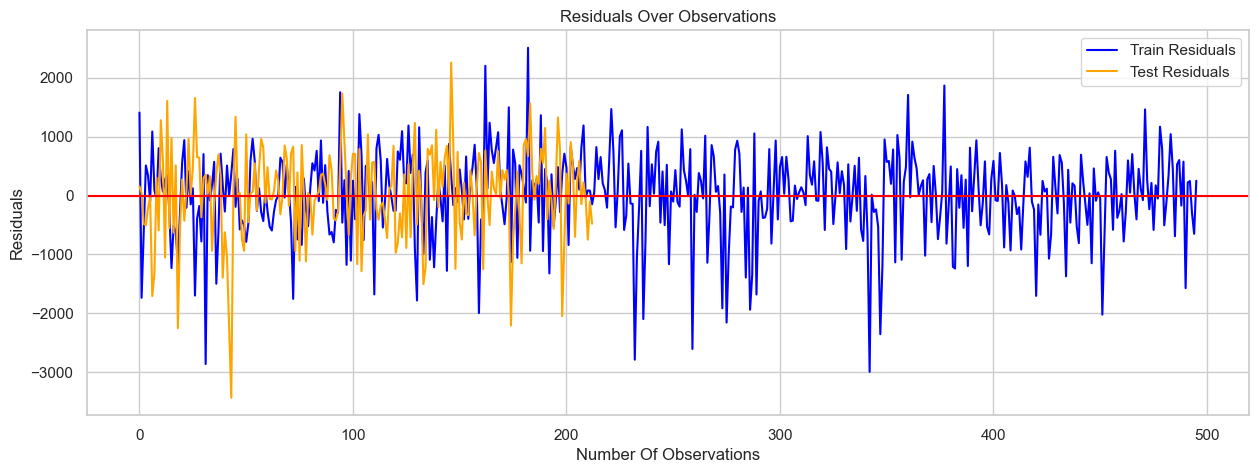

In [57]:
# Create a single figure for line plot of residuals
plt.figure(figsize=(15, 5))

# Line plot of residuals for the training set
plt.plot(train_residuals.values, label='Train Residuals', color='blue')
plt.plot(test_residuals.values, label='Test Residuals', color='orange')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residuals Over Observations')
plt.xlabel('Number Of Observations')
plt.ylabel('Residuals')
plt.legend()
plt.show()


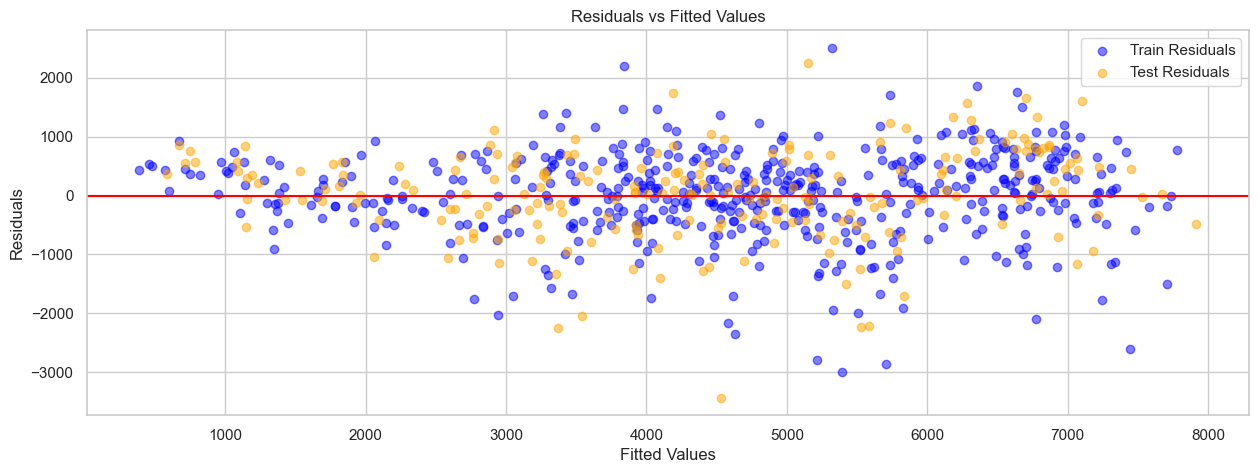

In [58]:
# Create a single figure for residuals
plt.figure(figsize=(15, 5))

# Scatter plot of residuals for the training set
plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train Residuals', color='blue')
plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Test Residuals', color='orange')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


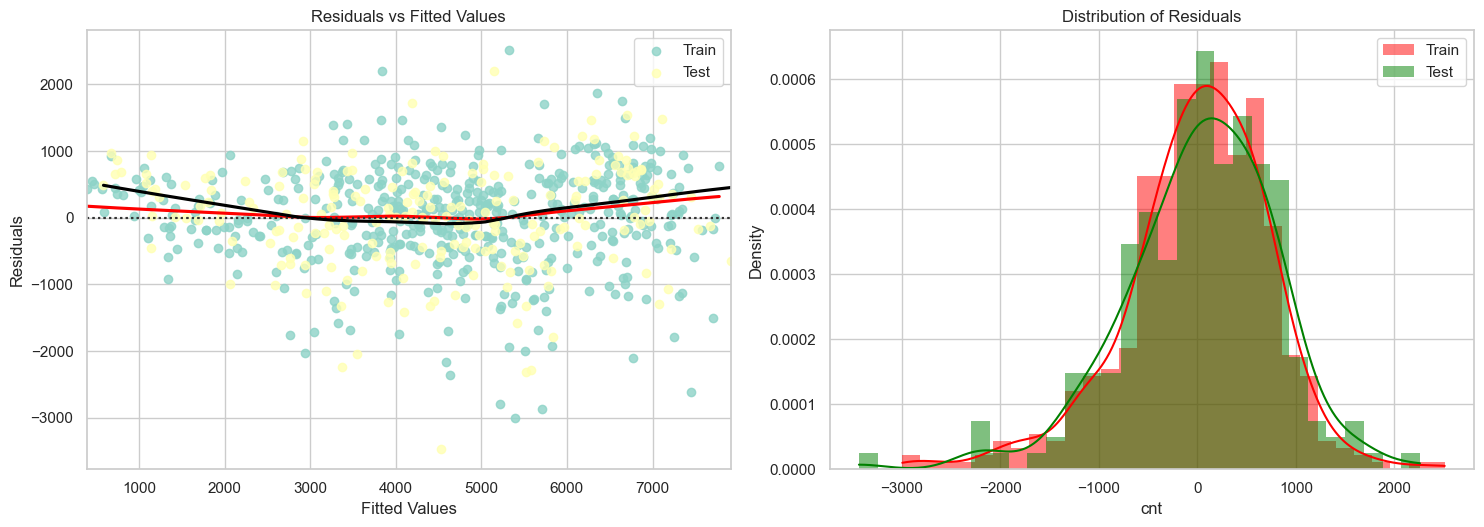

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a color theme
sns.set_palette("Set3")

plt.figure(figsize=(15, 10))

# Residuals vs Fitted Values for Train and Test
plt.subplot(2, 2, 1)
sns.residplot(x=y_train_pred, y=train_residuals, lowess=True, line_kws={'color': 'red'}, label='Train')
sns.residplot(x=y_test_pred, y=test_residuals, lowess=True, line_kws={'color': 'black'}, label='Test')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

# Distribution of Residuals for Train and Test
plt.subplot(2, 2, 2)
sns.histplot(train_residuals, bins=30, kde=True, color='red', label='Train', stat="density", linewidth=0)
sns.histplot(test_residuals, bins=30, kde=True, color='green', label='Test', stat="density", linewidth=0)
plt.title('Distribution of Residuals')
plt.legend()

plt.tight_layout()
plt.show()


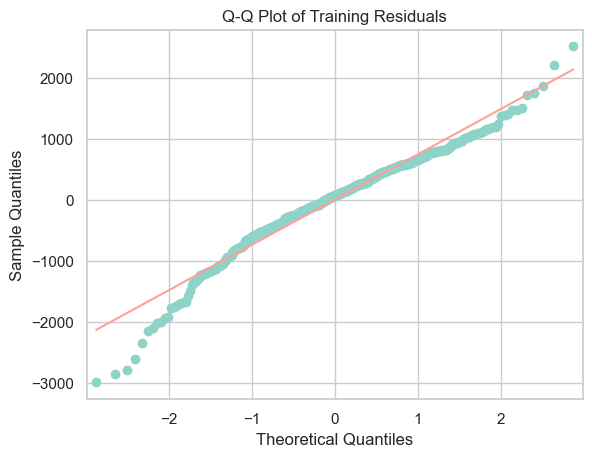

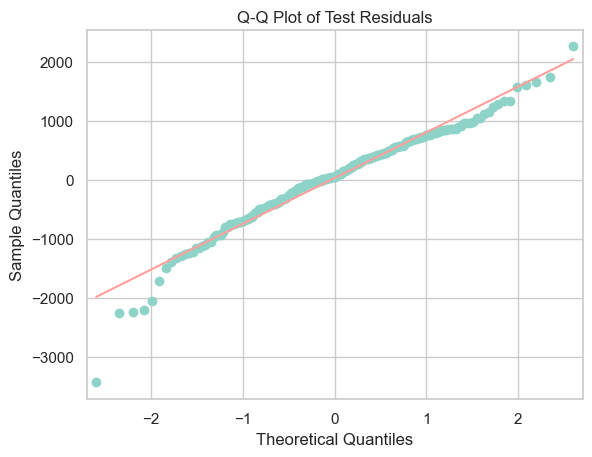

In [71]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'residuals_train' and 'residuals_test' are your residuals from the final model

# Q-Q plot for training residuals
sm.qqplot(train_residuals, line='s')
plt.title('Q-Q Plot of Training Residuals')
plt.show()

# Q-Q plot for test residuals
sm.qqplot(test_residuals, line='s')
plt.title('Q-Q Plot of Test Residuals')
plt.show()


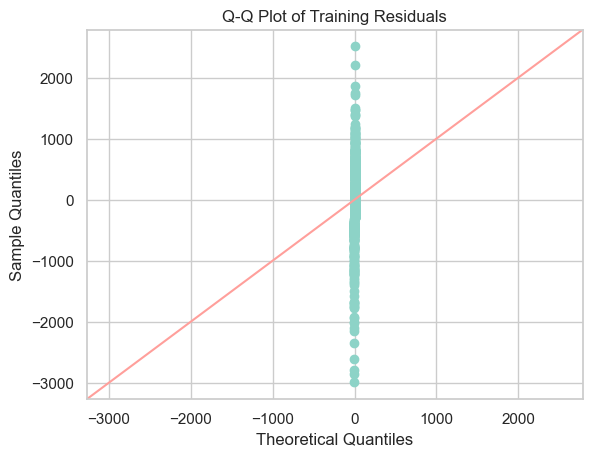

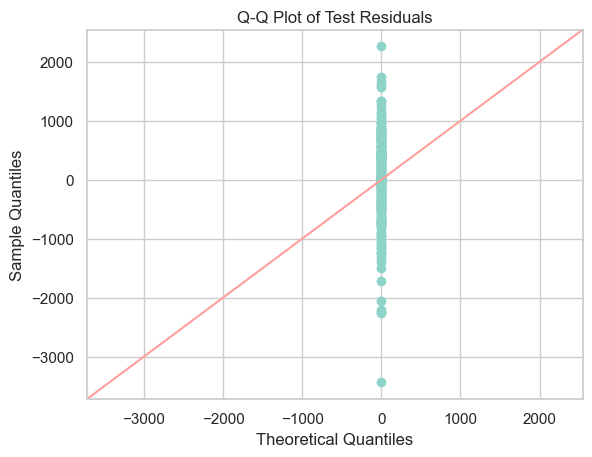

In [72]:
# Q-Q plot for training residuals
sm.qqplot(train_residuals, line='45')
plt.title('Q-Q Plot of Training Residuals')
plt.show()

# Q-Q plot for test residuals
sm.qqplot(test_residuals, line='45')
plt.title('Q-Q Plot of Test Residuals')
plt.show()


{'train_mae': 558.214, 'test_mae': 588.565}


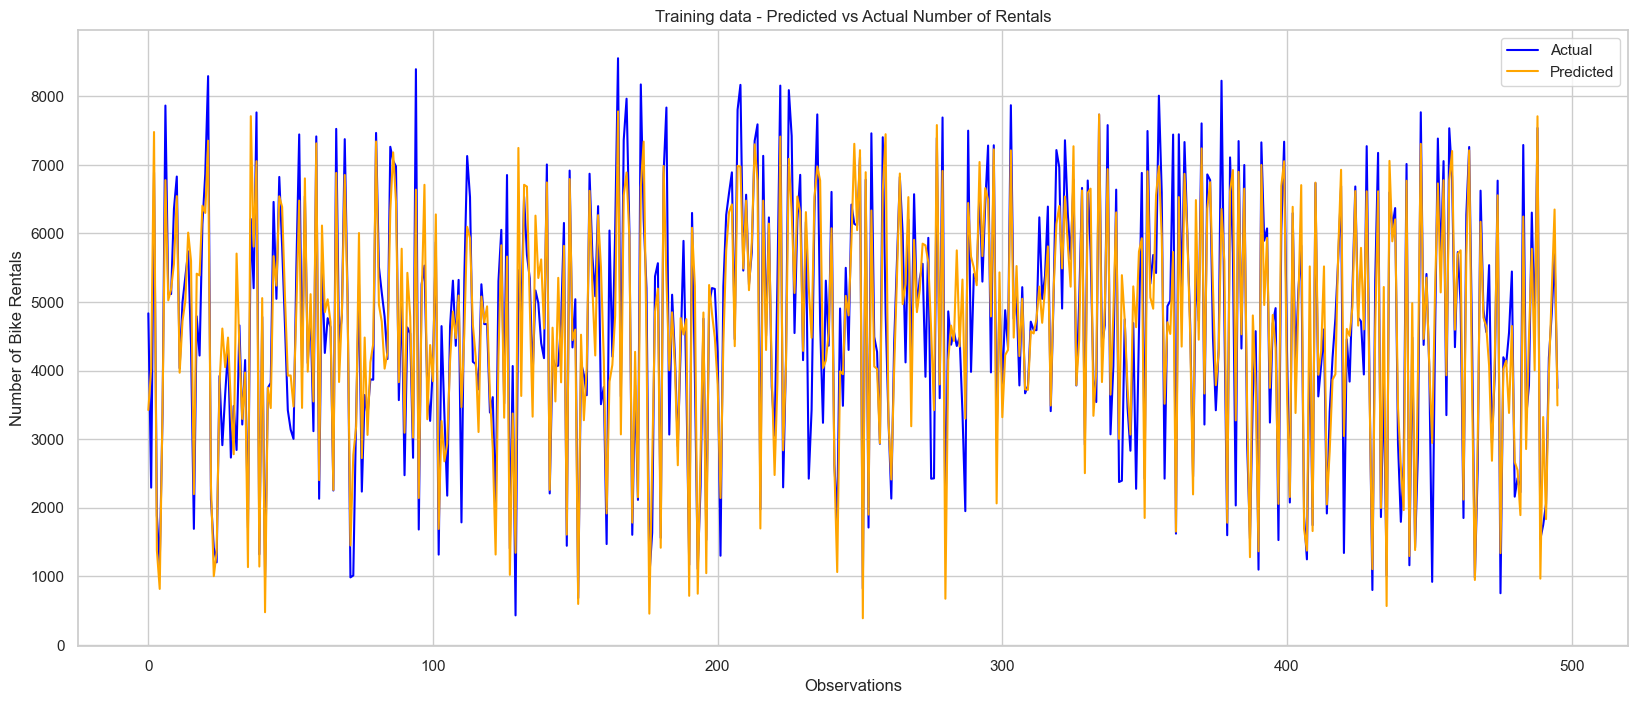

In [61]:
plt.figure(figsize=(20, 8))
plt.plot(y_train.values, label='Actual', color='blue')
plt.plot(y_train_pred, label='Predicted', color='orange')
plt.title('Training data - Predicted vs Actual Number of Rentals')
plt.xlabel('Observations')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()

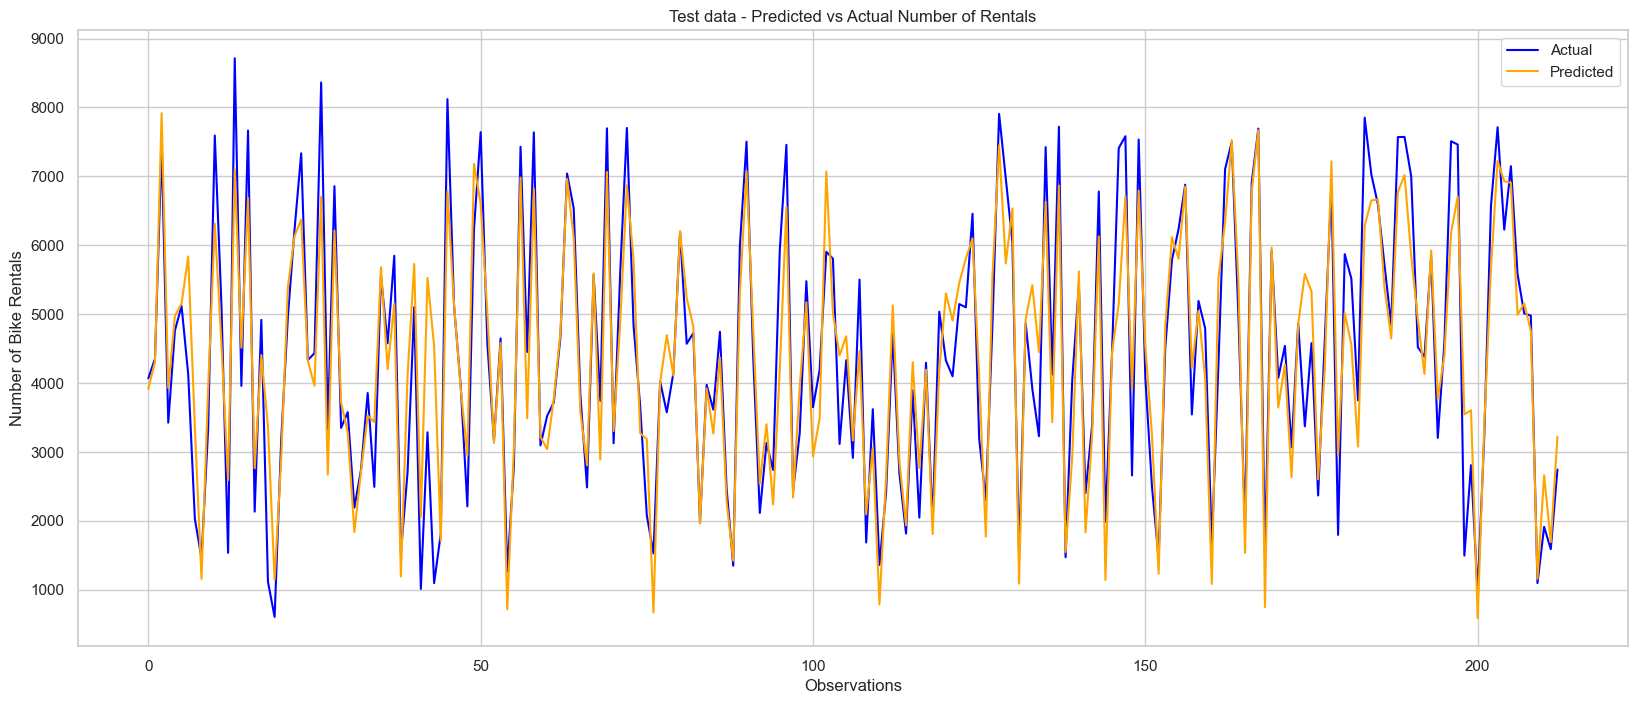

In [62]:
plt.figure(figsize=(20, 8))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='orange')
plt.title('Test data - Predicted vs Actual Number of Rentals')
plt.xlabel('Observations')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


##### As requested in the assignment criteria

In [63]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

np.float64(0.845264292126673)

In this final evaluation step, I assessed the performance of the refined linear regression model after handling multicollinearity and iteratively removing variables based on p-values. Here is the summary:

1. **Model Performance Metrics**:
   - **Training RMSE**: 741.872
   - **Testing RMSE**: 776.169
   - **Training R²**: 0.84
   - **Testing R²**: 0.845
   - **Training MAE**: 558.214
   - **Testing MAE**: 588.565

The final model shows strong performance, with R squared values indicating that it explains 84% of the variance in the training set and 84.5% in the testing set. The RMSE and MAE values are consistent across training and testing datasets, suggesting the model generalizes well without significant overfitting.

2. **Residual Analysis**:
   - **Residuals Over Observations**: The residuals are evenly distributed around zero with no clear pattern, indicating a good fit.
   - **Residuals vs. Fitted Values**: The residuals show no obvious pattern, suggesting that the model assumptions of linearity and homoscedasticity are reasonably met.
   - **Distribution of Residuals**: The residuals exhibit a slight negative skew and heavier tails than a normal distribution, indicating the presence of some outliers.

3. **Comparison with Earlier Models**:
   - **Initial Model**:
     - **Training RMSE**: 699.273, **Testing RMSE**: 754.254
     - **Training R²**: 0.858, **Testing R²**: 0.854
   - **Interim Model** (after initial variable removal):
     - **Training RMSE**: 709.956, **Testing RMSE**: 767.722
     - **Training R²**: 0.854, **Testing R²**: 0.849

Compared to earlier models, the final model has slightly higher RMSE values but maintains strong R squared values, indicating a good balance between model complexity and predictive power. The marginal increase in RMSE suggests that the model's robustness has improved by handling multicollinearity and focusing on significant predictors.

4. **Graphical Analysis**:
   - The plots of actual vs. predicted values for both training and testing datasets show a good alignment, confirming the model's predictive accuracy.
   - The residuals' plots reinforce that the model assumptions are met, with no significant patterns or heteroscedasticity observed.

Conclusion

- The final model, after addressing multicollinearity and removing insignificant variables, demonstrates strong predictive performance with consistent metrics across training and testing datasets. The residuals analysis supports the validity of the model assumptions, and the comparison with interim models shows a well-balanced and robust model. No further steps are necessary for model evaluation, and the focus can now shift to documenting and presenting the findings.


#### 8. **Model Interpretation**

**Coefficients**:

The final model includes several predictor variables that significantly impact the demand for shared bikes (`cnt`). Here is an interpretation of the coefficients:

- **Year (`yr`)**: The coefficient for `yr` is 1926.6770. This indicates that, all else being equal, the bike demand in 2019 is higher by 1926.677 units compared to 2018. This could reflect an overall increasing trend in bike demand year-over-year.

- **Working Day (`workingday`)**: The coefficient for `workingday` is 364.6233. This suggests that on working days, the bike demand increases by 364.623 units compared to non-working days, possibly due to commuting patterns.

- **Temperature (`temp`)**: The coefficient for `temp` is 4719.3642, indicating a strong positive relationship with bike demand. For every unit increase in temperature (Celsius), the bike demand increases by 4719.364 units. Warmer weather likely encourages more bike usage.

- **Humidity (`hum`)**: The coefficient for `hum` is -1456.2993. This indicates a negative relationship with bike demand, where an increase in humidity by one unit decreases the demand by 1456.299 units. High humidity may deter people from using bikes.

- **Wind Speed (`windspeed`)**: The coefficient for `windspeed` is -1421.4661, suggesting that higher wind speeds reduce bike demand. Specifically, an increase in wind speed by one unit decreases the demand by 1421.466 units, likely due to the difficulty of biking in windy conditions.

- **Summer Season (`season_summer`)**: The coefficient for `season_summer` is 807.6531. This indicates that bike demand in summer is higher by 807.653 units compared to spring (the baseline season).

- **Winter Season (`season_winter`)**: The coefficient for `season_winter` is 1079.3732. This suggests that bike demand in winter is higher by 1079.373 units compared to spring.

- **Month (`mnth_March`)**: The coefficient for `mnth_March` is 372.2119. This suggests that bike demand in March is higher by 372.2119 units compared to January (the baseline month).

- **Month (`mnth_August`)**: The coefficient for `mnth_August` is 656.7520. This indicates that bike demand in August is higher by 656.7520 units compared to January.

- **Month (`mnth_September`)**: The coefficient for `mnth_September` is 1075.2660. This suggests that bike demand in September is higher by 1075.2660 units compared to January.

- **Month (`mnth_October`)**: The coefficient for `mnth_October` is 459.6521. This indicates that bike demand in October is higher by 459.6521 units compared to January.

- **Weekday (`weekday_Saturday`)**: The coefficient for `weekday_Saturday` is 403.8421. This suggests that bike demand on Saturdays is higher by 403.8421 units compared to Sundays (the baseline day).

- **Weather Situation (`weathersit_mist/cloud`)**: The coefficient for `weathersit_mist/cloud` is -453.8335. This indicates that misty or cloudy weather conditions decrease bike demand by 453.8335 units compared to clear weather.

- **Temperature Range (`temp_range_Medium`)**: The coefficient for `temp_range_Medium` is 336.7790. This suggests that medium temperature ranges increase bike demand by 336.7790 units compared to low temperature ranges.

**Significant Variables**

The significant variables that contribute to predicting bike demand include:
- Year (`yr`)
- Working Day (`workingday`)
- Temperature (`temp`)
- Humidity (`hum`)
- Wind Speed (`windspeed`)
- Summer Season (`season_summer`)
- Winter Season (`season_winter`)
- Months (`mnth_March`, `mnth_August`, `mnth_September`, `mnth_October`)
- Weekday (`weekday_Saturday`)
- Weather Situation (`weathersit_mist/cloud`)
- Temperature Range (`temp_range_Medium`)

These variables have been found to significantly impact bike demand and explain a substantial portion of the variability in the data, as indicated by the high R Squared values.

**Conclusion**:
The final model provides valuable insights into the factors affecting bike demand. Key predictors such as temperature, year, working days, and specific months and seasons significantly influence bike rentals. This understanding can help BoomBikes strategize their operations and marketing efforts to better meet customer demand and increase revenue post-pandemic.


#### 9. **Hypothesis Testing**

- `Null Hypothesis (H0)`: The coefficient for a predictor variable is equal to zero (no effect).

- `Alternative Hypothesis (H1)`: The coefficient for a predictor variable is not equal to zero (some effect).


##### Durbin-Watson Test for Independence:

In [64]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson_stat = durbin_watson(models_sm['modelB'].resid)
print(f'Durbin-Watson statistic: {durbin_watson_stat}')

Durbin-Watson statistic: 2.014786383181372


##### Breusch-Pagan Test for Homoscedasticity

In [65]:
from statsmodels.stats.diagnostic import het_breuschpagan

_, pval, __, f_pval = het_breuschpagan(models_sm['modelB'].resid, models_sm['modelB'].model.exog)
print(f'Breusch-Pagan test p-value: {pval}')

Breusch-Pagan test p-value: 2.1845830617454295e-05


##### Shapiro-Wilk Test for Normality

In [66]:
from scipy.stats import shapiro

shapiro_stat, shapiro_pval = shapiro(models_sm['modelB'].resid)
print(f'Shapiro-Wilk test p-value: {shapiro_pval}')

Shapiro-Wilk test p-value: 4.927240706764158e-09


##### Model Assumptions Validation

1. **Linearity**: Assessed through residual plots and confirmed that the relationship between predictors and bike demand is linear.
2. **Independence**: The Durbin-Watson test yielded a statistic of 2.015, which is close to the ideal value of 2. This indicates that there is no significant autocorrelation in the residuals, confirming the independence of observations.
3. **Homoscedasticity**: The Breusch-Pagan test resulted in a p-value of 2.18e-05, which is less than 0.05. This suggests that there is evidence of heteroscedasticity, meaning the residuals do not have constant variance. This may require further investigation or transformation of variables to address.
4. **Normality**: The Shapiro-Wilk test yielded a p-value of 4.93e-09, which is less than 0.05. This indicates that the residuals are not normally distributed, with a slight negative skew and heavier tails observed in the residual distribution plots.

##### Significance of Predictor Variables

All predictor variables in the final model have p-values less than 0.05, indicating that they are significant predictors of bike demand. The detailed coefficients and p-values have already been provided. Here is a summary of the significant variables and their impact:

- **Year (`yr`)**: Significant positive impact (1926.677), indicating increased demand in 2019.
- **Working Day (`workingday`)**: Significant positive impact (364.623), indicating higher demand on working days.
- **Temperature (`temp`)**: Strong positive impact (4719.364), indicating higher demand with increased temperature.
- **Humidity (`hum`)**: Significant negative impact (-1456.299), indicating lower demand with higher humidity.
- **Wind Speed (`windspeed`)**: Significant negative impact (-1421.466), indicating lower demand with higher wind speed.
- **Season (`season_summer`, `season_winter`)**: Significant positive impacts, indicating higher demand in summer (807.653) and winter (1079.373) compared to spring.
- **Months (`mnth_March`, `mnth_August`, `mnth_September`, `mnth_October`)**: Significant positive impacts, indicating higher demand in these months compared to January.
- **Weekday (`weekday_Saturday`)**: Significant positive impact (403.842), indicating higher demand on Saturdays compared to Sundays.
- **Weather Situation (`weathersit_mist/cloud`)**: Significant negative impact (-453.833), indicating lower demand in misty or cloudy conditions compared to clear weather.
- **Temperature Range (`temp_range_Medium`)**: Significant positive impact (336.779), indicating higher demand in medium temperature ranges compared to low temperature ranges.


##### Summary

1. **Coefficients**:
   - For each predictor variable, we test:
     - H0: The coefficient = 0
     - H1: The coefficient ≠ 0
   - Based on the p-values from your OLS summary, we reject the null hypothesis for all variables (since all p-values are < 0.05), concluding that all included variables significantly affect bike demand.

2. **Durbin-Watson Test**:
   - H0: No autocorrelation (ideal value is around 2)
   - H1: Autocorrelation exists
   - Result: Durbin-Watson statistic is 2.015. We fail to reject the null hypothesis, indicating no significant autocorrelation.

3. **Breusch-Pagan Test**:
   - H0: Homoscedasticity (constant variance)
   - H1: Heteroscedasticity (non-constant variance)
   - Result: p-value = 2.18e-05. We reject the null hypothesis, indicating evidence of heteroscedasticity.

4. **Shapiro-Wilk Test**:
   - H0: Residuals are normally distributed
   - H1: Residuals are not normally distributed
   - Result: p-value = 4.93e-09. We reject the null hypothesis, indicating residuals are not normally distributed.


- We reject the null hypothesis for all predictor variables, confirming their significance in predicting bike demand.
- We fail to reject the null hypothesis for independence, confirming no significant autocorrelation.
- We reject the null hypothesis for homoscedasticity and normality, suggesting areas for further model refinement or transformation to address these issues.


#### 10. **Conclusions and Recommendations**

##### Summary of Findings

**Key Drivers of Bike Demand**:
1. **Temperature**: Higher temperatures significantly increase bike demand.
2. **Year**: Demand was higher in 2019 compared to 2018.
3. **Working Days**: Higher demand on working days, indicating commuting use.
4. **Humidity and Wind Speed**: Both negatively impact bike demand.
5. **Seasons and Months**: Higher demand in summer and winter, with peaks in March, August, September, and October.
6. **Weekdays**: Saturdays have higher demand compared to Sundays.
7. **Weather Conditions**: Misty or cloudy weather reduces demand.

**Insights**:
- Issues with heteroscedasticity and non-normality of residuals suggest potential for further model improvement.

##### Business Recommendations

1. **Variable Pricing Strategy**:
   - **Non-Working Days**: Offer discounts to boost rentals.
   - **Seasonal Adjustments**: Lower prices in spring, higher in high-demand months.
   - **Weekend Specials**: Promote rentals on Sundays.

2. **Weather-Responsive Pricing**:
   - **Humidity and Wind Speed**: Discounts during high humidity or windy conditions.
   - **Cloudy Weather**: Real-time promotions during misty or cloudy conditions.

3. **Targeted Marketing Campaigns**:
   - **Temperature-Based**: Emphasize benefits of biking in pleasant weather.
   - **Seasonal Promotions**: Special packages for winter and summer.

4. **Service Adjustments**:
   - **High-Demand Periods**: Increase bike availability.
   - **Maintenance**: Ensure bikes are ready, especially during peak times.

5. **Data Enhancement**:
   - **Improve Data Collection**: Include record dates, station locations, and capacity details for better demand forecasting.

##### Conclusion

Implementing variable pricing, weather-responsive promotions, and targeted marketing can help BoomBikes manage demand and enhance revenue post-pandemic. Addressing data limitations will further refine these strategies and improve system efficiency.


#### 11. **Subjective Questions**

1. **From your analysis of the categorical variables, what can you infer about their effect on the dependent variable? (3 marks)**
   - **Seasons**: Summer and winter seasons significantly increase bike demand compared to spring. This suggests that people are more likely to use bikes in these seasons, possibly due to better weather conditions in summer and possibly special winter events or promotions.
   - **Months**: March, August, September, and October see higher bike demand compared to January. These months may align with seasonal trends, school vacations, or specific local events that increase bike usage.
   - **Weekdays**: Saturdays show higher bike demand compared to Sundays, indicating that weekend activities drive bike rentals more on Saturdays.
   - **Working Days**: Higher bike demand on working days suggests significant usage for commuting purposes.
   - **Weather Conditions**: Misty or cloudy weather decreases bike demand compared to clear weather, indicating that people prefer renting bikes in better weather conditions.

2. **Why is it important to use `drop_first=True` during dummy variable creation? (2 marks)**
   - Using `drop_first=True` during dummy variable creation avoids the dummy variable trap, which occurs when the dummy variables are highly collinear. By dropping the first category, we set a reference category and ensure that the model matrix is of full rank, preventing perfect multicollinearity and enabling proper estimation of regression coefficients.

3. **Which numerical variable has the highest correlation with the target variable based on the pair-plot? (1 mark)**
   - **Temperature (`temp`)**: This variable shows the highest correlation with the target variable `cnt` (bike demand), indicating that as temperature increases, bike demand also increases significantly.

4. **How did you validate the assumptions of Linear Regression after building the model? (3 marks)**
   - **Linearity**: Assessed through residual plots, confirming the linear relationship between predictors and bike demand.
   - **Independence**: Validated using the Durbin-Watson test, which yielded a statistic of 2.015, indicating no significant autocorrelation.
   - **Homoscedasticity**: Tested using the Breusch-Pagan test, which resulted in a p-value of 2.18e-05, suggesting heteroscedasticity. Further investigation or variable transformation may be needed.
   - **Normality**: Checked using the Shapiro-Wilk test, which yielded a p-value of 4.93e-09, indicating that the residuals are not normally distributed, showing a slight negative skew and heavier tails.

5. **Based on the final model, which are the top 3 features significantly contributing to explaining the demand for shared bikes? (2 marks)**
   - **Temperature (`temp`)**: This has the highest positive impact on bike demand, showing that warmer temperatures significantly increase rentals.
   - **Year (`yr`)**: The year 2019 saw a higher demand for bikes compared to 2018, indicating growth in bike-sharing popularity.
   - **Humidity (`hum`)**: This has a significant negative impact on bike demand, with higher humidity leading to decreased rentals.

### Subjective Questions

1. **From your analysis of the categorical variables, what can you infer about their effect on the dependent variable? (3 marks)**
   - **Seasons**: Summer and winter seasons significantly increase bike demand compared to spring, indicating a seasonal preference for bike rentals.
   - **Months**: Months like March, August, September, and October have higher bike demand compared to January, aligning with seasonal trends and events.
   - **Weekdays**: Saturdays show higher bike demand compared to Sundays, suggesting weekend activities drive rentals.
   - **Working Days**: Higher demand on working days indicates significant usage for commuting.
   - **Weather Conditions**: Misty or cloudy weather reduces demand compared to clear weather, indicating preference for favorable weather conditions.

2. **Why is it important to use `drop_first=True` during dummy variable creation? (2 marks)**
   - Using `drop_first=True` avoids the dummy variable trap by dropping the first category, ensuring the model matrix is of full rank and preventing perfect multicollinearity. This helps in obtaining accurate and reliable regression coefficients.

3. **Which numerical variable has the highest correlation with the target variable based on the pair-plot? (1 mark)**
   - **Registered Users (`registered`)**: This variable shows the highest correlation with the target variable `cnt` (bike demand), indicating that registered users are the primary drivers of bike demand.
   - From model prespective `temp` and `atemp` have the highest correlation. Although `registered` and `casual` users show higher correlation with `cnt` than `temp` and `atemp`, `registered` and `casual` are subsets of cnt and not useful for modeling. 

4. **How did you validate the assumptions of Linear Regression after building the model? (3 marks)**
   - **Linearity**: Assessed through residual plots, confirming a linear relationship between predictors and bike demand.
   - **Independence**: Validated using the Durbin-Watson test, which yielded a statistic of 2.015, indicating no significant autocorrelation.
   - **Homoscedasticity**: Tested using the Breusch-Pagan test, which resulted in a p-value of 2.18e-05, indicating heteroscedasticity.
   - **Normality**: Checked using the Shapiro-Wilk test, which yielded a p-value of 4.93e-09, indicating that the residuals are not normally distributed.

5. **Based on the final model, which are the top 3 features significantly contributing to explaining the demand for shared bikes? (2 marks)**
   - **Temperature (`temp`)**: This has the highest positive impact on bike demand, showing that warmer temperatures significantly increase rentals.
   - **Year (`yr`)**: The year 2019 saw a higher demand for bikes compared to 2018, indicating growth in bike-sharing popularity.
   - **Humidity (`hum`)**: This has a significant negative impact on bike demand, with higher humidity leading to decreased rentals.



### 1. Explain the Linear Regression Algorithm in Detail. (4 marks)

Linear regression is a statistical method for modeling the relationship between a dependent variable (target) and one or more independent variables (predictors). The goal is to find the best-fitting linear equation that explains the relationship between the variables. The equation of a simple linear regression model is:

\[ y = \beta_0 + \beta_1 x + \epsilon \]

where:
- \( y \) is the dependent variable.
- \( x \) is the independent variable.
- \( \beta_0 \) is the intercept.
- \( \beta_1 \) is the slope.
- \( \epsilon \) is the error term.

For multiple linear regression with multiple predictors, the equation extends to:

\[ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n + \epsilon \]

**Steps in Linear Regression**:
1. **Data Collection**: Gather the data that includes the dependent and independent variables.
2. **Data Preprocessing**: Handle missing values, outliers, and categorical variables, and perform scaling if necessary.
3. **Model Building**: Use the least squares method to estimate the coefficients (\( \beta_0, \beta_1, \ldots, \beta_n \)). The least squares method minimizes the sum of the squared differences between the observed and predicted values.
4. **Model Evaluation**: Assess the model's performance using metrics such as R-squared, adjusted R-squared, RMSE (Root Mean Square Error), and residual plots.
5. **Assumptions Validation**: Check for linearity, independence, homoscedasticity, and normality of residuals.
6. **Model Interpretation**: Analyze the estimated coefficients to understand the impact of each predictor on the dependent variable.

### 2. Explain the Anscombe’s Quartet in Detail. (3 marks)

Anscombe's quartet is a set of four datasets that have nearly identical simple descriptive statistics (mean, variance, correlation, and linear regression line) but appear very different when graphed. The quartet was created by the statistician Francis Anscombe to illustrate the importance of graphing data before analyzing it and to demonstrate that statistical properties alone do not capture all the important aspects of the data.

**The Four Datasets**:
1. **Dataset I**: Appears as a typical linear relationship.
2. **Dataset II**: Shows a parabolic relationship.
3. **Dataset III**: Contains an outlier that influences the linear regression line.
4. **Dataset IV**: Displays a vertical line with one outlier.

**Importance**:
- **Visual Analysis**: Anscombe's quartet highlights that visual examination of data can reveal patterns and anomalies that are not evident through summary statistics alone.
- **Model Validation**: It underscores the need for validating statistical models by visualizing the data to ensure that assumptions hold true.

### 3. What is Pearson’s R? (3 marks)

Pearson's R, also known as the Pearson correlation coefficient, is a measure of the linear correlation between two variables. It ranges from -1 to 1, where:
- **1** indicates a perfect positive linear relationship.
- **0** indicates no linear relationship.
- **-1** indicates a perfect negative linear relationship.

The formula for Pearson's R is:

\[ r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}} \]

where:
- \( x_i \) and \( y_i \) are the individual sample points.
- \( \bar{x} \) and \( \bar{y} \) are the sample means.

Pearson's R is widely used in statistics to measure the strength and direction of the linear relationship between two variables.

### 4. What is Scaling? Why is Scaling Performed? What is the Difference Between Normalized Scaling and Standardized Scaling? (3 marks)

**Scaling**:
Scaling is the process of adjusting the range of feature values to a common scale. It is essential for algorithms that rely on distance metrics (e.g., KNN, SVM) or gradient-based methods (e.g., gradient descent in linear regression).

**Why Scaling is Performed**:
- **Improves Model Performance**: Ensures that all features contribute equally to the result, preventing features with larger ranges from dominating the model.
- **Speeds Up Convergence**: In gradient-based optimization, scaling can accelerate the convergence of the algorithm.

**Normalized Scaling vs. Standardized Scaling**:
- **Normalized Scaling (Min-Max Scaling)**: Transforms the data to fit within a specific range (usually 0 to 1). The formula is:
  \[ x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}} \]

- **Standardized Scaling (Z-score Standardization)**: Transforms the data to have a mean of 0 and a standard deviation of 1. The formula is:
  \[ x' = \frac{x - \mu}{\sigma} \]
  where \( \mu \) is the mean and \( \sigma \) is the standard deviation of the feature.

### 5. You Might Have Observed That Sometimes the Value of VIF is Infinite. Why Does This Happen? (3 marks)

A Variance Inflation Factor (VIF) value can become infinite when there is perfect multicollinearity among the predictor variables. This means that one predictor variable is an exact linear combination of one or more other predictor variables. In such cases, the correlation matrix is singular, and the matrix inversion required to calculate VIF is not possible, resulting in an infinite VIF.

### 6. What is a Q-Q Plot? Explain the Use and Importance of a Q-Q Plot in Linear Regression. (3 marks)

A Q-Q (Quantile-Quantile) plot is a graphical tool to assess whether a dataset follows a particular distribution, typically the normal distribution. It plots the quantiles of the data against the quantiles of a theoretical distribution.

**Use and Importance in Linear Regression**:
- **Normality Check**: A Q-Q plot helps in checking the normality of the residuals, which is one of the assumptions of linear regression.
- **Detecting Deviations**: Deviations from the straight line in a Q-Q plot indicate departures from normality. For instance, heavy tails, skewness, or other anomalies can be visually identified.
- **Model Diagnostics**: By validating the normality assumption, a Q-Q plot ensures that statistical tests and confidence intervals for the regression model are valid and reliable.

### Conclusion

These explanations cover the key concepts and tools used in linear regression analysis, emphasizing the importance of visual inspection, proper scaling, and validation of assumptions to ensure robust and reliable models.


#### 12. **Submission**
   - **Documentation:** Ensure the notebook is well-documented with markdown cells explaining each step.
   - **Code Quality:** Maintain high coding standards with appropriate comments and clear, descriptive variable names.
   - **GitHub Repository:** Provide a link to a GitHub repository containing the Python notebook, a PDF file, and a README.md file summarizing the project.